<a href="https://colab.research.google.com/github/jacopomanenti01/Graph-Neural-Networks/blob/main/GNN_for_Anti_Money_Laundering_in_Bitcoin_Node_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install torch torchvision torchaudio torch-geometric
!pip install --upgrade scipy networkx



import pandas as pd
import matplotlib as mpt
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import torch
from tabulate import tabulate
from google.colab import files
import numpy as np

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import NormalizeFeatures
from torch.optim import Adam

import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.manifold import TSNE










In [3]:
!unzip elliptic
%cd ./elliptic_bitcoin_dataset

Archive:  elliptic.zip
  inflating: elliptic_bitcoin_dataset/elliptic_txs_classes.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv  
  inflating: elliptic_bitcoin_dataset/elliptic_txs_features.csv  
/content/elliptic_bitcoin_dataset


# Dataset

As reported in [Kaggle](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set) "*The Elliptic Data Set maps Bitcoin transactions to real entities belonging to licit categories (exchanges, wallet providers, miners, licit services, etc.) versus illicit ones (scams, malware, terrorist organizations, ransomware, Ponzi schemes, etc.). The task on the dataset is to classify the illicit and licit nodes in the graph.

If you make use of the Elliptic Data Set in your research, please consider citing*"

Dataset Content

* Node: represents a transaction.
  - Each has 166 features
  - Labeled as ✅ licit, ❌ illicit or 🤷 unknown

* Edge: represents a flow of Bitcoins between transaction A and transaction B


Before we start, here are a couple concepts you should know for better understanding of the following code:



$$
\begin{array}{|l|l|p{5cm}|l|}
\hline
\textbf{Concept} & \textbf{Math Notation} & \textbf{Description} & \textbf{More Information} \\
\hline
\text{Graph} & G & \text{Defined as pair } G = (V, E), \text{ where } V \text{ is a set of vertices and } E \text{ is a set of edges} & \text{Wikipedia: Graph (discrete mathematics)} \\
& & \text{which are unordered pairs } v_1, v_2 \text{ of vertices.} & \\
\hline
\text{Degree} & deg & \text{Number of edges that are incident to a vertex.} & \text{Wikipedia: Degree (graph theory)} \\
\hline
\text{Component} & & \text{Connected subgraph that is not part of any larger connected subgraph.} & \text{Wikipedia: Component (graph theory)} \\
\hline
\end{array}
$$

🚨 In the following notebook we will always call the graph G, the set of nodes V and the set of edges E. 🚨

# Overview

Let's start by getting an overview of the datasets.



In [4]:
elliptic_txs_features = pd.read_csv('./elliptic_txs_features.csv', header=None)
elliptic_txs_classes = pd.read_csv('./elliptic_txs_classes.csv')
elliptic_txs_edgelist = pd.read_csv('./elliptic_txs_edgelist.csv')

In [ ]:
elliptic_txs_features

0    1         2         3         4          5         6    \
0       230425980    1 -0.171469 -0.184668 -1.201369  -0.121970 -0.043875   
1         5530458    1 -0.171484 -0.184668 -1.201369  -0.121970 -0.043875   
2       232022460    1 -0.172107 -0.184668 -1.201369  -0.121970 -0.043875   
3       232438397    1  0.163054  1.963790 -0.646376  12.409294 -0.063725   
4       230460314    1  1.011523 -0.081127 -1.201369   1.153668  0.333276   
...           ...  ...       ...       ...       ...        ...       ...   
203764  173077460   49 -0.145771 -0.163752  0.463609  -0.121970 -0.043875   
203765  158577750   49 -0.165920 -0.123607  1.018602  -0.121970 -0.043875   
203766  158375402   49 -0.172014 -0.078182  1.018602   0.028105 -0.043875   
203767  158654197   49 -0.172842 -0.176622  1.018602  -0.121970 -0.043875   
203768  157597225   49 -0.012037 -0.132276  0.463609  -0.121970 -0.043875   

             7          8         9    ...       157       158       159  \
0      -0.113002  -0.061584 -0.162097  ... -0.562153 -0.600999  1.461330   
1      -0.113002  -0.061584 -0.162112  ...  0.947382  0.673103 -0.979074   
2      -0.113002  -0.061584 -0.162749  ...  0.670883  0.439728 -0.979074   
3       9.782742  12.414558 -0.163645  ... -0.577099 -0.613614  0.241128   
4       1.312656  -0.061584 -0.163523  ... -0.511871 -0.400422  0.517257   
...          ...        ...       ...  ...       ...       ...       ...   
203764 -0.113002  -0.061584 -0.135803  ... -0.577099 -0.613614  0.241128   
203765 -0.113002  -0.061584 -0.156418  ...  0.162722  0.010822  1.461330   
203766  0.054722  -0.061584 -0.163626  ...  1.261246  1.985050  1.461330   
203767 -0.113002  -0.061584 -0.163501  ... -0.397749 -0.411776  1.461330   
203768 -0.113002  -0.061584  0.001027  ... -0.577099 -0.613614  0.241128   

             160       161       162       163       164       165       166  
0       1.461369  0.018279 -0.087490 -0.131155 -0.097524 -0.120613 -0.119792  
1      -0.978556  0.018279 -0.087490 -0.131155 -0.097524 -0.120613 -0.119792  
2      -0.978556 -0.098889 -0.106715 -0.131155 -0.183671 -0.120613 -0.119792  
3       0.241406  1.072793  0.085530 -0.131155  0.677799 -0.120613 -0.119792  
4       0.579382  0.018279  0.277775  0.326394  1.293750  0.178136  0.179117  
...          ...       ...       ...       ...       ...       ...       ...  
203764  0.241406  0.018279 -0.087490 -0.131155 -0.097524 -0.120613 -0.119792  
203765  1.461369 -0.098889 -0.087490 -0.084674 -0.140597 -1.760926 -1.760984  
203766  1.461369  0.018279 -0.087490 -0.131155 -0.097524 -0.120613 -0.119792  
203767  1.461369 -0.098889 -0.087490 -0.084674 -0.140597  1.519700  1.521399  
203768  0.241406 -0.098889 -0.087490 -0.084674 -0.140597  1.519700  1.521399  

[203769 rows x 167 columns]

In [ ]:
print(f"{elliptic_txs_features.shape[0]:8,}")

 203,769


In [5]:
# Rename the elliptic_txs_features columns
elliptic_txs_features.columns = ['txId'] + [f'V{i}' for i in range(1, 167)]


Let's get an overview on the distribution of the classes.



In [6]:

print(f"""Shapes
{4*' '}Features : {elliptic_txs_features.shape[0]:8,} (rows)  {elliptic_txs_features.shape[1]:4,} (cols)
{4*' '}Classes  : {elliptic_txs_classes.shape[0]:8,} (rows)  {elliptic_txs_classes["class"].unique().shape[0]} (labes)
{4*' '}Edgelist : {elliptic_txs_edgelist.shape[0]:8,} (rows)
""")
elliptic_txs_classes['class_mapped'] = elliptic_txs_classes['class'].replace({'1': 'illicit', '2': 'licit'})

100 * elliptic_txs_classes['class_mapped'].value_counts(normalize=True)

Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)  3 (labes)
    Edgelist :  234,355 (rows)



class_mapped
unknown    77.148634
licit      20.620899
illicit     2.230467
Name: proportion, dtype: float64

See labels

In [ ]:

percentage_distribution = round(100 * elliptic_txs_classes['class_mapped'].value_counts(normalize=True), 2)
class_counts = elliptic_txs_classes['class_mapped'].value_counts()


classes_df = pd.DataFrame({
    'Class Mapped': elliptic_txs_classes['class_mapped'].unique(),
    'Class Raw': elliptic_txs_classes['class'].unique(),
    'Counts': class_counts.values,
    'Percentage': percentage_distribution.values,
})
classes_df

Class Mapped Class Raw  Counts  Percentage
0      unknown   unknown  157205       77.15
1        licit         2   42019       20.62
2      illicit         1    4545        2.23

In [ ]:
num_nodes = elliptic_txs_features.shape[0]
num_edges = elliptic_txs_edgelist.shape[0]

print(f"Number of nodes: {num_nodes:,}")
print(f"Number of edges: {num_edges:,}")

Number of nodes: 203,769
Number of edges: 234,355


In [ ]:
# Create graph from the edgelist.
G = nx.from_pandas_edgelist(elliptic_txs_edgelist, 'txId1', 'txId2')


In [ ]:
# Take a subgraph for connectivity metrics computations


num_connected_components = nx.number_connected_components(G)
print(f"Number of connected components: {num_connected_components}")
sub = max(nx.connected_components(G), key=len)
G_sub = G.subgraph(sub)



print(f"Giant component - Number of nodes: {G_sub.number_of_nodes():,}")
print(f"Giant component - Number of edges: {G_sub.number_of_edges():,}")


Number of connected components: 49
Giant component - Number of nodes: 7,880
Giant component - Number of edges: 9,164


# Utilis Functions

In [ ]:
def get_color_map(top , metric ):
  """
    Multiplies two numbers and returns the result.

    Args:
        top (pd.Series): list of top node metric.
        metric (dict): connectivity metric.

    Returns:
        G: subgraph containig the top nodes.
        norm: The normalized color map used as input to the colorbar.
        node_color_norm: The normalized color map for the nodes colors.
    """

  top_nodes = top.tolist()
  # create the subgraph
  G_subgraph = G.subgraph(top_nodes)
  # create the color map
  node_color = [metric[node] for node in top_nodes]
  norm = mpt.colors.Normalize(vmin=min(node_color), vmax=max(node_color))
  node_color_norm = [norm(value) for value in node_color]


  return G_subgraph,norm, node_color_norm


In [7]:
import random

def set_seed(seed):
    """
    Fix the random seed for reproducibility.

    Parameters:
    seed (int): The seed value to use.
    """
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (for single GPU)
    torch.cuda.manual_seed_all(seed)  # PyTorch GPU (for all GPUs)
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disable benchmark mode for reproducibility

# 🔍 Exploratory Data Analysis (EDA)


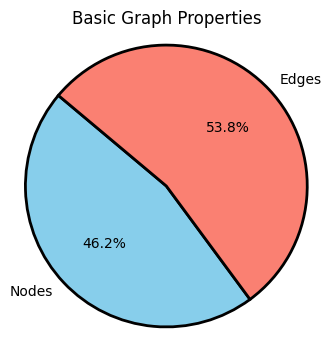

In [ ]:
import matplotlib.pyplot as plt

num_nodes = G_sub.number_of_nodes()
num_edges = G_sub.number_of_edges()

plt.figure(figsize=(4, 4))
sizes = [num_nodes, num_edges]
labels = ['Nodes', 'Edges']
colors = ['skyblue', 'salmon']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140,
        wedgeprops = {'edgecolor' : 'black',
                      'linewidth': 2,
                      'antialiased': True})
plt.title('Basic Graph Properties')
plt.axis('equal')
plt.show()

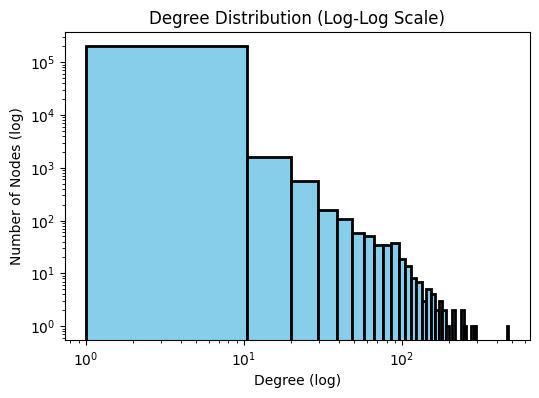

In [ ]:
# --- Degree Distribution (Log-Log Scale) ---
plt.figure(figsize=(6, 4))
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees, bins=50, log=True, color='skyblue', edgecolor='black', linewidth=2.0)
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree (log)')
plt.ylabel('Number of Nodes (log)')
plt.show()

# Graph connectivity

Shortest paths length distribution in the giant component


In [ ]:
paths = dict(nx.shortest_path_length(G_sub))
# If neither the source nor target are specified, return an iterator over (source, dictionary)
# where dictionary is keyed by target to shortest path length from source to that target.
paths_val = [l for val in paths.values() for l in val.values()]
plt.figure(figsize=(6, 4))
plt.hist(paths_val, bins = 50, edgecolor = "black")
plt.title("Shortest Path Length Distribution")
plt.xlabel("Shortest Path Length")
plt.ylabel("Number of Nodes")
plt.show()



KeyboardInterrupt: 

Degree Centrality

In [ ]:
degree_centrality = nx.degree_centrality(G_sub)
top_ten_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10] # sort by degree
dp_top_ten_degree_centrality = pd.DataFrame(top_ten_degree_centrality, columns=['node', 'degree_centrality'])


# create the color map
G_subgraph, norm, node_color_norm= get_color_map(dp_top_ten_degree_centrality["node"],degree_centrality )

# Plot top degree
print("Top 10 node centrality")
print("##########")
print(dp_top_ten_degree_centrality)

Top 10 node centrality
##########
        node  degree_centrality
0      89273           0.036680
1  232438397           0.020434
2    2881273           0.018150
3  230658142           0.017007
4    2758467           0.013453
5    2881274           0.012311
6  232029206           0.007615
7   43560505           0.006346
8    2880930           0.006219
9   27405707           0.005077


<ipython-input-22-213f3490c8cc>:4: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Degree Centrality')


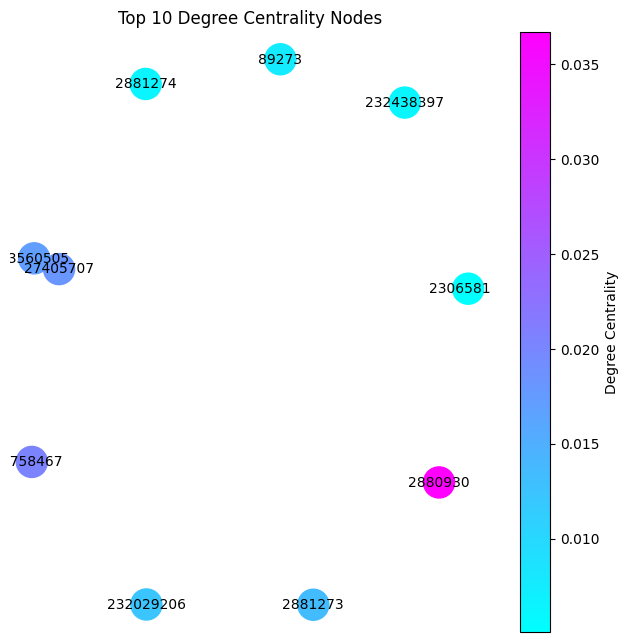

In [ ]:
plt.figure(figsize=(6, 6))
nx.draw(G_subgraph, with_labels = True,edge_color = "grey", node_size = 500,  font_size = 10, node_color = node_color_norm , cmap= mpt.cm.cool )
plt.title('Top 10 Degree Centrality Nodes')
plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Degree Centrality')
plt.show()

Betweeness centrality

In [ ]:
betweenness_centrality= nx.betweenness_centrality(G_sub)

TypeError: sorted expected 1 argument, got 2

In [ ]:
top_betweenness_centrality = sorted(betweenness_centrality.items(), key= lambda x:x[1], reverse = True )[:10]
pd_top_betweenness_centrality = pd.DataFrame(top_betweenness_centrality, columns = ['node', 'betweenness_centrality'])


# create the color map
G_subgraph, norm, node_color_norm= get_color_map(pd_top_betweenness_centrality["node"],betweenness_centrality )

# Plot top degree
print("Top 10 node centrality")
print("##########")
print(pd_top_betweenness_centrality)

Top 10 node centrality
##########
        node  betweenness_centrality
0      89273                0.485234
1  232438397                0.296735
2    2758467                0.164410
3    2881273                0.156171
4    2881274                0.135059
5    2893846                0.104127
6  230402893                0.092297
7  230658142                0.087068
8   34174548                0.081942
9    2880930                0.078085


<ipython-input-32-cf3d4502fbdb>:4: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Betweenness Centrality')


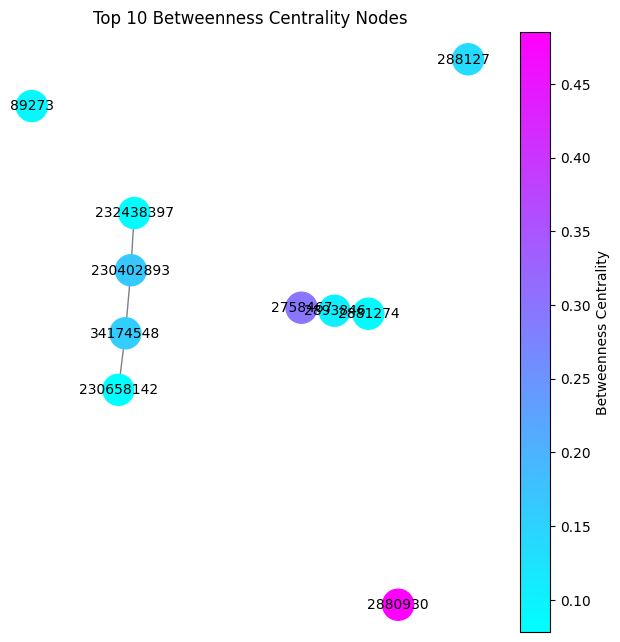

In [ ]:
plt.figure(figsize=(6, 6))
nx.draw(G_subgraph, with_labels = True, edge_color = "grey", node_size = 500, font_size = 10, node_color=node_color_norm, cmap=mpt.cm.cool)
plt.title('Top 10 Betweenness Centrality Nodes')
plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Betweenness Centrality')
plt.show()

Closeness centrality

In [ ]:
closeness_centrality = nx.closeness_centrality(G_sub)
top_ten_closeness_centrality = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
pd_top_closeness_centrality = pd.DataFrame(top_ten_closeness_centrality, columns=['node', 'closeness_centrality'])

# print
print("top 10 Closeness Centrality")
print("##########")
print(pd_top_closeness_centrality)


top 10 Closeness Centrality
##########
        node  closeness_centrality
0      89273              0.162511
1  232438397              0.155365
2  230438845              0.151394
3  230439793              0.151394
4  230683551              0.149009
5  230537117              0.148888
6  230451730              0.147738
7  232031824              0.146728
8  203465969              0.146725
9  232054853              0.146205


<ipython-input-35-67a4616262c9>:6: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Closeness Centrality')


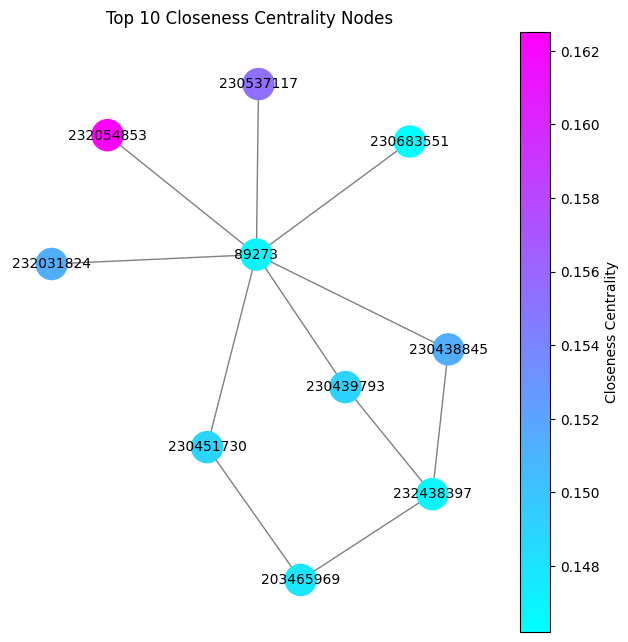

In [ ]:
G_subgraph, norm, node_color_norm= get_color_map(pd_top_closeness_centrality["node"],closeness_centrality )
# Plot
plt.figure(figsize=(6, 6))
nx.draw(G_subgraph, with_labels = True,edge_color = "grey", node_size = 500,  font_size = 10, node_color = node_color_norm , cmap= mpt.cm.cool )
plt.title('Top 10 Closeness Centrality Nodes')
plt.colorbar(mpt.cm.ScalarMappable(norm=norm, cmap=mpt.cm.cool), label='Closeness Centrality')
plt.show()

# Graph visualization

In [ ]:
# Identify nodes that are top in each centrality measure and their combinations.
top_nodes_degree = set([node for node, _ in top_ten_degree_centrality])
top_nodes_betweenness = set([node for node, _ in top_betweenness_centrality])
top_nodes_closeness = set([node for node, _ in top_ten_closeness_centrality])

top_nodes_degree_betweenness = top_nodes_degree & top_nodes_betweenness
top_nodes_closeness_and_degree = top_nodes_closeness & top_nodes_degree
top_nodes_closeness_and_betweenness = top_nodes_closeness & top_nodes_betweenness
top_nodes_all_three = top_nodes_closeness & top_nodes_degree & top_nodes_betweenness

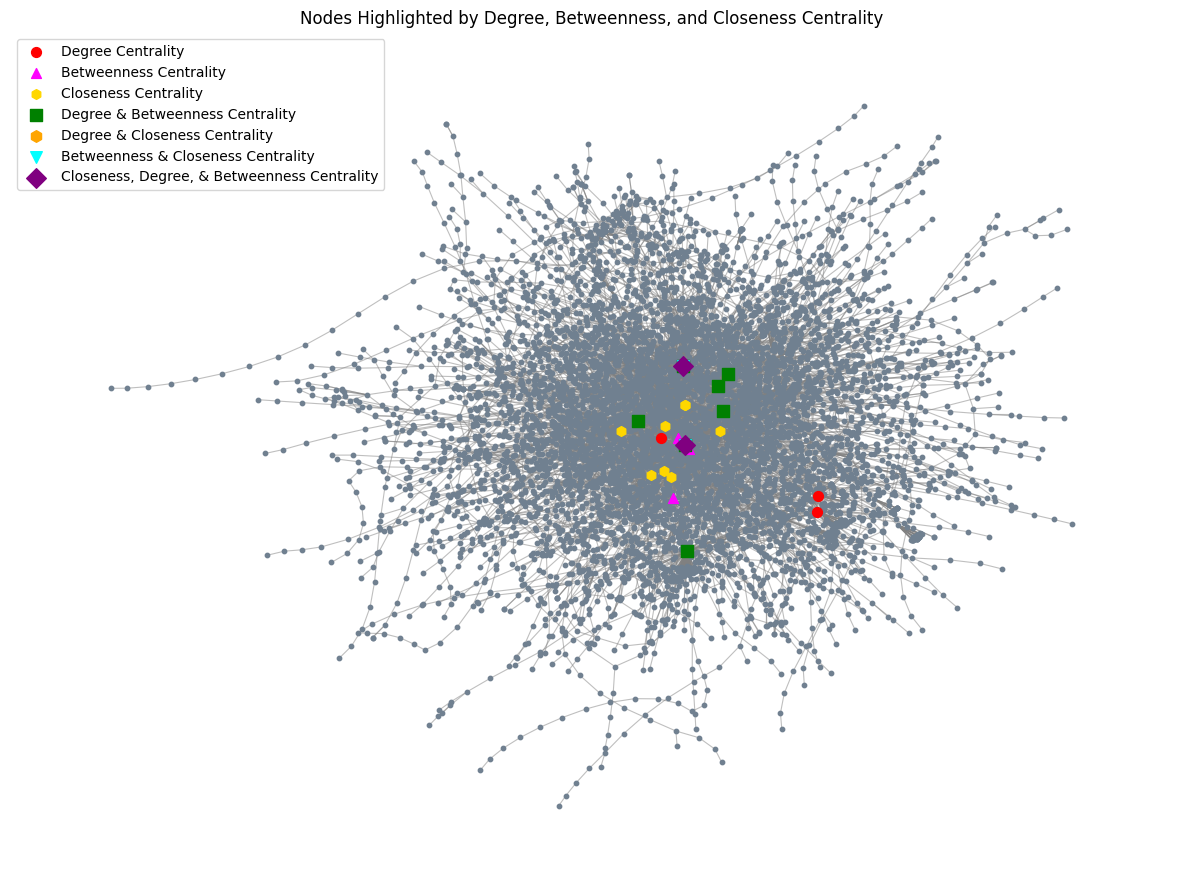

In [ ]:
plt.figure(figsize=(15, 11))

pos = nx.spring_layout(G_sub)
# Draw all nodes first.
nx.draw_networkx_nodes(G_sub,pos,  node_color='slategrey', node_size=10)

# Draw nodes with specific centrality measures.
nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_degree - top_nodes_degree_betweenness - top_nodes_closeness_and_degree),
                       node_color='red', node_size=50, node_shape='o', label='Degree Centrality')


nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_betweenness - top_nodes_degree_betweenness - top_nodes_closeness_and_betweenness),
                       node_color='magenta', node_size=50, node_shape='^', label='Betweenness Centrality')


nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_closeness - top_nodes_closeness_and_degree - top_nodes_closeness_and_betweenness),
                       node_color='gold', node_size=50, node_shape='h', label='Closeness Centrality')

nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_degree_betweenness), node_color='green', node_size=80, node_shape='s',
                       label='Degree & Betweenness Centrality')

nx.draw_networkx_nodes(G_sub, pos, nodelist=list(top_nodes_closeness_and_degree), node_color='orange', node_size=70, node_shape='h',
                       label='Degree & Closeness Centrality')

nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_closeness_and_betweenness), node_color='cyan', node_size=70, node_shape='v',
                       label='Betweenness & Closeness Centrality')

nx.draw_networkx_nodes(G_sub,pos,  nodelist=list(top_nodes_all_three), node_color='purple', node_size=100, node_shape='D',
                       label='Closeness, Degree, & Betweenness Centrality')

# Draw edges.
nx.draw_networkx_edges(G_sub,pos, width=0.8, edge_color='gray', alpha=0.5)

plt.axis('off')
plt.title('Nodes Highlighted by Degree, Betweenness, and Closeness Centrality')
plt.legend(scatterpoints=1)
plt.show()

# Create the Data Object for Pytorch Geometric


Set the device

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
tx_id_mapping = {key: idx  for idx, key in enumerate(elliptic_txs_features['txId'])}

elliptic_txs_edgelist['Id1'] = elliptic_txs_edgelist['txId1'].map(tx_id_mapping)
elliptic_txs_edgelist['Id2'] = elliptic_txs_edgelist['txId2'].map(tx_id_mapping)


edge_index = torch.tensor(elliptic_txs_edgelist[['Id1', 'Id2']].values.T, dtype=torch.long)
edge_index

tensor([[     0,      2,      4,  ..., 201921, 201480, 201954],
        [     1,      3,      5,  ..., 202042, 201368, 201756]])

In [10]:
nodes_features = torch.tensor(elliptic_txs_features.drop('txId', axis=1).values, dtype=torch.float)
nodes_features.shape

torch.Size([203769, 166])

In [11]:
mapped_labels = elliptic_txs_classes["class"].replace({"unknown":"0"})
mapped_labels = elliptic_txs_classes["class"].replace({"1": "0", "2": "1", "unknown":"2"})

mapped_labels = mapped_labels.astype(int)
mapped_labels.value_counts()

class
2    157205
1     42019
0      4545
Name: count, dtype: int64

In [12]:
labels = torch.tensor(mapped_labels.values, dtype=torch.long)
labels

tensor([2, 2, 2,  ..., 0, 2, 2])

In [13]:
# Create a pythorch geometric data object
from torch_geometric.data import Data

graph = Data(x=nodes_features,
            edge_index=edge_index,
            y=labels)


# Train, Validation, Test masks


In [14]:
from itertools import permutations

def load_split_dataset2(data , train_ratio=0.8, val_ratio=0.1):


    num_known_label = (data.y == 0) | (data.y ==1)
    num_known_nodes = num_known_label.sum().item()

    permutations = torch.randperm(num_known_nodes)
    train_size = int(0.8 * num_known_nodes)
    val_size = int(0.1 * num_known_nodes)
    test_size = num_known_nodes - train_size - val_size


    data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

    train_indices = num_known_label.nonzero(as_tuple=True)[0][permutations[:train_size]]
    val_indices = num_known_label.nonzero(as_tuple=True)[0][permutations[train_size:train_size + val_size]]
    test_indices = num_known_label.nonzero(as_tuple=True)[0][permutations[train_size + val_size:]]


    data.train_mask[train_indices] = True
    data.val_mask[val_indices] = True
    data.test_mask[test_indices] = True


    # Check that the splits have no overlap
    assert torch.sum(data.train_mask & data.val_mask) == 0, "Train and validation masks overlap!"
    assert torch.sum(data.train_mask & data.test_mask) == 0, "Train and test masks overlap!"
    assert torch.sum(data.val_mask & data.test_mask) == 0, "Validation and test masks overlap!"

    print(f"Train: {data.train_mask.sum().item()}, Val: {data.val_mask.sum().item()}, Test: {data.test_mask.sum().item()}")
    return data

In [ ]:
def load_split_dataset(data, train_ratio=0.8, val_ratio=0.1):
    num_nodes = data.num_nodes
    indices = torch.randperm(num_nodes)

    train_size = int(train_ratio * num_nodes)
    val_size = int(val_ratio * num_nodes)
    test_size = num_nodes - train_size - val_size

    print(f"Splitting {num_nodes} nodes into:")
    print(f"  Train: {train_size}, Val: {val_size}, Test: {test_size}")

    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    data.train_mask[train_indices] = True
    data.val_mask[val_indices] = True
    data.test_mask[test_indices] = True

    # Debugging outputs
    print("Checking mask properties...")
    print(f"Train nodes: {data.train_mask.sum().item()} (expected {train_size})")
    print(f"Val nodes: {data.val_mask.sum().item()} (expected {val_size})")
    print(f"Test nodes: {data.test_mask.sum().item()} (expected {test_size})")

    assert (data.train_mask & data.val_mask).sum() == 0, "Train and Val masks overlap!"
    assert (data.train_mask & data.test_mask).sum() == 0, "Train and Test masks overlap!"
    assert (data.val_mask & data.test_mask).sum() == 0, "Val and Test masks overlap!"

    return data


In [15]:
set_seed(42)
data = load_split_dataset2(graph)

data = data.to(device)
data

Train: 37251, Val: 4656, Test: 4657


Data(x=[203769, 166], edge_index=[2, 234355], y=[203769], train_mask=[203769], val_mask=[203769], test_mask=[203769])

In [16]:
n_classes = data.y[data.train_mask].unique().shape[0]
n_classes

2

## Statistics

In [ ]:
cond1 = (data.y == 0)
cond2 = (data.y == 1)

cond3 = (data.y == 2)

tot_illicit = cond1.sum().item()
tot_licit = cond2.sum().item()

tot_unk = cond3.sum().item()
tot = tot_illicit+ tot_licit


In [ ]:
train_illicit = (data.y[data.train_mask == True] == 0).sum().item()
train_licit = (data.y[data.train_mask == True] == 1).sum().item()
train_unkwon = (data.y[data.train_mask == True] == 2).sum().item()

val_illicit = (data.y[data.val_mask == True] == 0).sum().item()
val_licit = (data.y[data.val_mask == True] == 1).sum().item()
val_unkwon = (data.y[data.val_mask == True] == 2).sum().item()


test_illicit = (data.y[data.test_mask == True] == 0).sum().item()
test_licit = (data.y[data.test_mask == True] == 1).sum().item()
test_unkwon = (data.y[data.test_mask == True] == 2).sum().item()



split_dic = {
    "licti + illicit + unkwon": [train_licit + train_illicit + train_unkwon,
                                 val_licit + val_illicit + val_unkwon,
                                 test_licit + test_illicit + test_unkwon],

    "#unkwon": [train_unkwon, val_unkwon, test_unkwon],
    "#licit": [train_licit, val_licit, test_licit],
    "#illicit": [train_illicit, val_illicit, test_illicit],
    "%licit": [100 * train_licit / (train_licit + val_licit + test_licit) , 100 * val_licit / (train_licit + val_licit + test_licit), 100 * test_licit / (train_licit + val_licit + test_licit)],
    "%illicit": [100 * train_illicit / (train_illicit + val_illicit + test_illicit), 100 * val_illicit / (train_illicit + val_illicit + test_illicit), 100 * test_illicit / (train_illicit + val_illicit + test_illicit)],
}

split_df = pd.DataFrame(split_dic, index=["train", "val", "test"])
split_df


licti + illicit + unkwon  #unkwon  #licit  #illicit     %licit  \
train                    163015   125780   33615      3620  79.999524   
val                       20376    15725    4201       450   9.997858   
test                      20378    15700    4203       475  10.002618   

        %illicit  
train  79.647965  
val     9.900990  
test   10.451045

The percentages respects the splitting condition we have set.
Maybe a more balancing could be better

# Utilis

In [19]:
!pip install tqdm
from tqdm import tqdm


# calculate the weights based on the class distribution

def train(epoch,
          data,
          model,
          lr,
          wd):
  data = data.to(device)

  # computes the weights
  weights = data.y[data.train_mask].unique(return_counts=True)[1].cpu().numpy()
  weights = 1/weights
  weights = weights/weights.sum()
  class_weights = torch.tensor(weights, dtype = torch.float).to(device)

  # set the paramenters
  lr = lr
  opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # 5e-4
  criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

  # initialize lists
  loss_history = []

  for i in tqdm(range(0, epoch)):
    # set training mode
    model.train()
    # reset gradients
    opt.zero_grad()
    # get probabilities
    out = model(data)
    # compute the loss
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    # compute gradients
    loss.backward()
    # optimize
    opt.step()

    # Append predictions and labels

    if i % 100 == 0:
        print(f"The current loss is {loss:.4f}")
        loss_history.append(loss.item())  # Store loss for this epoch



  return loss_history


In [20]:
def test(data, model, bin):
  model.eval()
  with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
  print(f"Test Accuracy: {test_acc:.4f}")
  y_test = pred[data.test_mask].cpu().numpy()
  y = data.y[data.test_mask].cpu().numpy()

  if bin:
      auc = roc_auc_score(y, y_test)  # For binary classification

  else:
      probs = torch.softmax(out[data.test_mask], dim = 1).cpu().numpy()
      auc = roc_auc_score(y, probs, multi_class='ovr')  # For binary classification

  print(classification_report(y, y_test))

  return test_acc, y_test, auc

In [21]:
def plot_acc(ax, data, labels, bin, title):
    # Generate the confusion matrix
    cm = confusion_matrix(data.y[data.test_mask].cpu(), labels)

    if bin:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['illicit', 'licit'])
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["unknown", 'illicit', 'licit'])

    # Plot the confusion matrix on the provided axes
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    ax.set_title(title)


In [22]:
def plot_loss(ax, loss_history, epochs, model):
  x = range(0, epochs +1, 100)
  ax.plot(x,loss_history, label='train_loss')
  ax.legend()
  ax.set_title(f"{model}: Train loss")
  ax.set_ylabel("CrossEntropy per epoch")
  ax.set_xlabel("Epoch")


In [23]:
from scipy.stats import wasserstein_distance
import numpy as np
from sklearn.manifold import TSNE

def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    # Visualize
    plt.figure(figsize=(8, 8))
    for i in range(len(set(labels))):
        indices = labels == i
        plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], label=f'Class {i}', alpha=0.7)
    plt.legend()
    plt.title(title)
    plt.show()

    # Wasserstein distance calculation between classes
    unique_classes = np.unique(labels)
    wasserstein_matrix = np.zeros((len(unique_classes), len(unique_classes)))

    for i in range(len(unique_classes)):
        for j in range(i+1, len(unique_classes)):
            class_i_embeddings = embeddings_2d[labels == unique_classes[i]]
            class_j_embeddings = embeddings_2d[labels == unique_classes[j]]

            # Calculate Wasserstein distance for x and y dimensions separately
            x_distance = wasserstein_distance(class_i_embeddings[:, 0], class_j_embeddings[:, 0])
            y_distance = wasserstein_distance(class_i_embeddings[:, 1], class_j_embeddings[:, 1])

            wasserstein_matrix[i, j] = np.mean([x_distance, y_distance])
            wasserstein_matrix[j, i] = wasserstein_matrix[i, j]

    return wasserstein_matrix

In [24]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

def evaluate_embeddings(embeddings, labels):
    metrics = {}

    # Silhouette Score (higher is better, range [-1, 1])
    metrics['silhouette'] = silhouette_score(embeddings, labels)


    # K-NN classification accuracy (higher is better)
    knn = KNeighborsClassifier(n_neighbors=5)
    metrics['knn_accuracy'] = cross_val_score(knn, embeddings, labels, cv=5).mean()

    return metrics



# Model_1

In [ ]:
import torch_geometric.transforms as T

# There is a problem with this
transform = T.Compose([T.NormalizeFeatures()])
data = transform(data)
print(data.is_directed())
data.x[:-1]

True


tensor([[0.0066, 0.0060, 0.0060,  ..., 0.0060, 0.0060, 0.0060],
        [0.0066, 0.0060, 0.0060,  ..., 0.0061, 0.0061, 0.0061],
        [0.0066, 0.0061, 0.0061,  ..., 0.0061, 0.0061, 0.0061],
        ...,
        [0.0274, 0.0057, 0.0057,  ..., 0.0057, 0.0050, 0.0050],
        [0.0276, 0.0058, 0.0058,  ..., 0.0058, 0.0058, 0.0058],
        [0.0278, 0.0058, 0.0058,  ..., 0.0058, 0.0066, 0.0066]],
       device='cuda:0')

Use a GCN Layer

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class MyMPL(torch.nn.Module):
  def __init__(self, input_dim, hidden_channels, output_dim):
    super(MyMPL, self).__init__()

    self.lin1 = torch.nn.Linear(input_dim, hidden_channels)
    self.lin2 = torch.nn.Linear(hidden_channels, output_dim)

  def forward(self, x):
    x = self.lin1(x)
    x = F.relu(x)
    x = self.lin2(x)
    return x

class GCN(torch.nn.Module):
    def __init__(self, input_dim , hidden_channels, n_classes, self_loops= False):
        super(GCN, self).__init__()

        # initialize the layers
        self.conv1 = GCNConv(input_dim, hidden_channels, add_self_loops = self_loops)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, add_self_loops = self_loops)
        self.mlp = MyMPL(hidden_channels, hidden_channels, n_classes)

    def forward(self, data, before = False):
        x, edge_index= data.x, data.edge_index
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing
        x = self.conv2(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, p=0.5, training=self.training)

        if before:
          return x

        # MPL layer
        x = self.mlp(x)

        # Output layer

        return x





GCN(
  (conv1): GCNConv(166, 64)
  (conv2): GCNConv(64, 64)
  (mlp): MyMPL(
    (lin1): Linear(in_features=64, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=2, bias=True)
  )
)


## Train

In [ ]:
seed = 42
set_seed(seed)
baseline = GCN(data.num_features, hidden_channels=64, n_classes=n_classes).to(device)

loss_baseline = train(epoch=1001,
      data=data,
      model = baseline,
      lr = .01,
      wd = 5e-4)

  1%|          | 8/1001 [00:00<00:26, 37.84it/s]

The current loss is 0.6932


 11%|█         | 108/1001 [00:02<00:19, 46.86it/s]

The current loss is 0.5179


 21%|██        | 208/1001 [00:04<00:16, 46.83it/s]

The current loss is 0.4939


 31%|███       | 308/1001 [00:06<00:14, 46.87it/s]

The current loss is 0.4837


 41%|████      | 408/1001 [00:08<00:12, 46.61it/s]

The current loss is 0.4802


 51%|█████     | 508/1001 [00:10<00:10, 46.84it/s]

The current loss is 0.4724


 61%|██████    | 608/1001 [00:13<00:08, 46.73it/s]

The current loss is 0.4746


 71%|███████   | 708/1001 [00:15<00:06, 46.63it/s]

The current loss is 0.4717


 81%|████████  | 808/1001 [00:17<00:04, 46.68it/s]

The current loss is 0.4736


 91%|█████████ | 908/1001 [00:19<00:01, 46.53it/s]

The current loss is 0.4759


100%|██████████| 1001/1001 [00:21<00:00, 46.63it/s]

The current loss is 0.4722


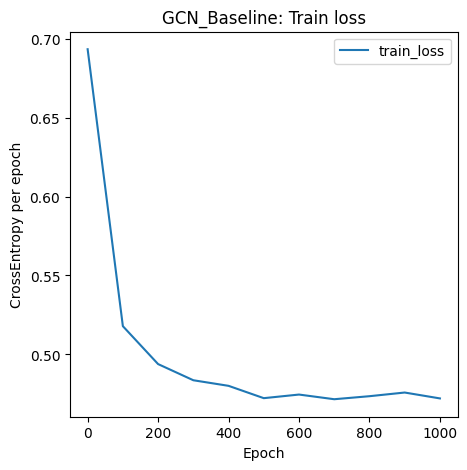

In [ ]:
fig, ax =  plt.subplots(figsize=(5, 5))
plot_loss(ax = ax, loss_history=loss_baseline,
              epochs= 1000,
              model =  "GCN_Baseline")


## Test

In [ ]:
test_acc_baseline, y_test_baseline, auc_baseline= test(data = data, model = baseline, bin = True)

Test Accuracy: 0.8561
              precision    recall  f1-score   support

           0       0.29      0.37      0.32       435
           1       0.93      0.91      0.92      4222

    accuracy                           0.86      4657
   macro avg       0.61      0.64      0.62      4657
weighted avg       0.87      0.86      0.86      4657



Model_ 1 accieved accuracy of: 0.8561305561520292


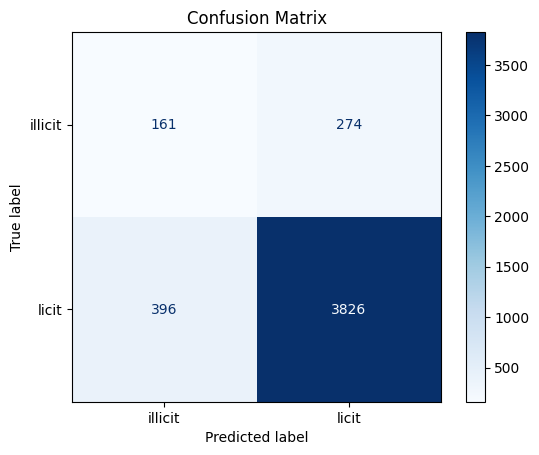

In [ ]:
print(f"Baseline accuracy of: {test_acc_baseline}")
print(f"Baseline auc of: {auc_baseline}")
plot_acc(data, y_test_baseline, bin = True)

The model is entirely biased towards predicting the unknown class for all inputs, regardless of the actual class.

## Visualiza Embeddings

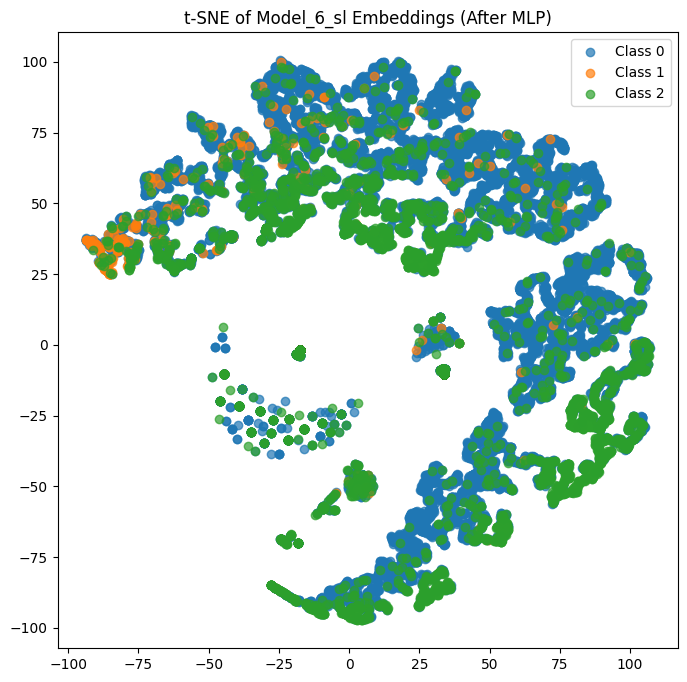

wasserstein distance Matrix:
[[0.         1.         0.57235375]
 [1.         0.         0.93959252]
 [0.57235375 0.93959252 0.        ]]


In [ ]:
baseline.eval()

with torch.no_grad():
  test_embeddings_1 = baseline.forward(data)[data.test_mask].cpu().numpy()

WS_GNN1 = plot_tsne(test_embeddings_1, data.y[data.test_mask].cpu().numpy(), 't-SNE of Model_6_sl Embeddings (After MLP)')
print(f"wasserstein distance Matrix:\n{WS_GNN1/np.max(WS_GNN1)}")

In [ ]:
WS_mean_GNN1 = WS_GNN1.mean()

In [ ]:
metrics_1 = evaluate_embeddings(test_embeddings_1, data.y[data.test_mask].cpu().numpy())
metrics_1

{'silhouette': -0.34639558, 'knn_accuracy': 0.6237271500429395}

 # Model 2


In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, BatchNorm

class MyMPL2(torch.nn.Module):
  def __init__(self, input_dim, hidden_channels, output_dim):
    super(MyMPL2, self).__init__()

    self.lin1 = torch.nn.Linear(input_dim, hidden_channels)
    self.lin2 = torch.nn.Linear(hidden_channels, output_dim)

  def forward(self, x):
    x = self.lin1(x)
    x = F.relu(x)
    x = self.lin2(x)
    return x

class MyGCN2(torch.nn.Module):
    def __init__(self,input_dim, hidden_channels, self_loops = False):
        super(MyGCN2, self).__init__()
        self.add_self_loops = self_loops

        # initialize the layers
        self.conv1 = GCNConv(input_dim, hidden_channels, add_self_loops= self_loops)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, add_self_loops= self_loops)
        self.bn1 = BatchNorm(hidden_channels)  # BatchNorm layer
        self.bn2 = BatchNorm(hidden_channels)  # BatchNorm layer

        self.mlp = MyMPL2(hidden_channels, hidden_channels, 3)

    def forward(self, data, before = False):
        x, edge_index = data.x, data.edge_index
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Apply BatchNorm after conv1
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Apply BatchNorm after conv1
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        if before:
          return x

        # MPL layer
        x = self.mlp(x)

        # Output layer

        return x





In [ ]:
model_2 = MyGCN2(input_dim = data.num_features, hidden_channels=64).to(device)
print(model_2)

MyGCN2(
  (conv1): GCNConv(166, 64)
  (conv2): GCNConv(64, 64)
  (bn1): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mlp): MyMPL2(
    (lin1): Linear(in_features=64, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=3, bias=True)
  )
)


## Train

In [ ]:
seed = 42
set_seed(seed)

loss = train(epoch=1001,
      data=data,
      model = model_2,
      lr = .01,
      wd = 5e-4)

  0%|          | 5/1001 [00:00<00:43, 23.05it/s]

The current loss is 1.1146


 10%|█         | 105/1001 [00:03<00:26, 34.00it/s]

The current loss is 0.9104


 20%|██        | 205/1001 [00:06<00:23, 33.72it/s]

The current loss is 0.8978


 30%|███       | 305/1001 [00:09<00:20, 33.69it/s]

The current loss is 0.8913


 40%|████      | 405/1001 [00:12<00:17, 34.08it/s]

The current loss is 0.8926


 50%|█████     | 505/1001 [00:14<00:14, 33.97it/s]

The current loss is 0.8875


 60%|██████    | 605/1001 [00:17<00:11, 33.61it/s]

The current loss is 0.8856


 70%|███████   | 705/1001 [00:20<00:08, 33.86it/s]

The current loss is 0.8896


 80%|████████  | 805/1001 [00:23<00:05, 33.54it/s]

The current loss is 0.8884


 90%|█████████ | 905/1001 [00:26<00:02, 33.88it/s]

The current loss is 0.8897


100%|██████████| 1001/1001 [00:29<00:00, 33.69it/s]

The current loss is 0.8835


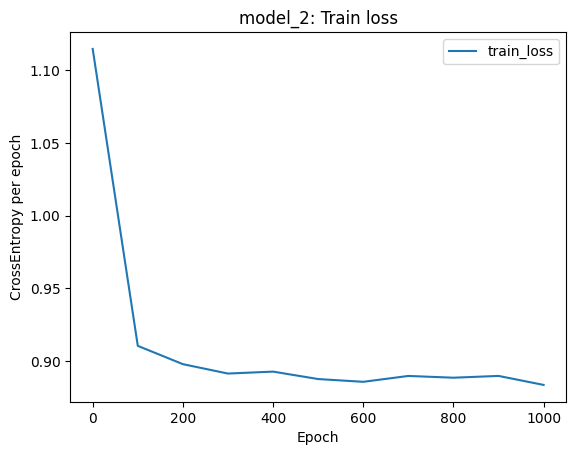

In [ ]:
plot_loss(loss_history=loss,
              epochs= 1000,
              model =  "model_2")


## Test

In [ ]:
test_acc, y_test= test(data = data, model = model_2)

Test Accuracy: 0.4607


Model_2 accieved accuracy of: 0.460679671205987


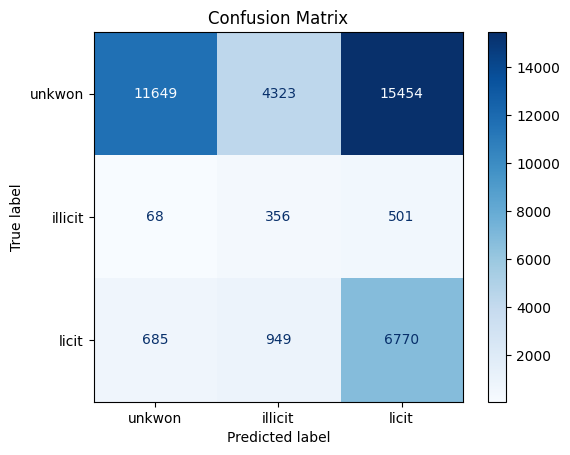

In [ ]:
print(f"Model_2 accieved accuracy of: {test_acc}")
plot_acc(data, y_test)

## Visualize Embeddings

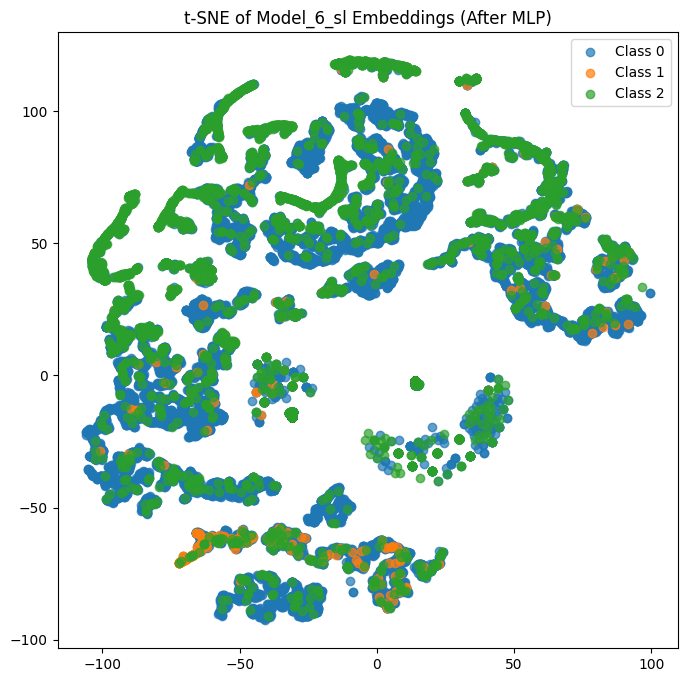

wasserstein distance Matrix:
[[0.         0.68677869 0.42732558]
 [0.68677869 0.         1.        ]
 [0.42732558 1.         0.        ]]


In [ ]:
model_2.eval()

with torch.no_grad():
  test_embeddings_2 = model_2.forward(data)[data.test_mask].cpu().numpy()

WS_GNN2 = plot_tsne(test_embeddings_2, data.y[data.test_mask].cpu().numpy(), 't-SNE of Model_6_sl Embeddings (After MLP)')
print(f"wasserstein distance Matrix:\n{WS_GNN2/np.max(WS_GNN2)}")

In [ ]:
WS_mean_GNN2 = WS_GNN2.mean()

In [ ]:
metrics_2 = evaluate_embeddings(test_embeddings_2, data.y[data.test_mask].cpu().numpy())
metrics_2

{'silhouette': -0.40547168, 'knn_accuracy': 0.6522144522144522}

# Adding self loops

## Train

In [ ]:
model_1_sl = MyGCN(input_dim = data.num_features, hidden_channels=64, self_loops = True).to(device)
model_2_sl = MyGCN2(input_dim = data.num_features, hidden_channels=64, self_loops = True).to(device)
print(model_1_sl)
print(model_2_sl)

MyGCN(
  (conv1): GCNConv(166, 64)
  (conv2): GCNConv(64, 64)
  (mlp): MyMPL(
    (lin1): Linear(in_features=64, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=3, bias=True)
  )
)
MyGCN2(
  (conv1): GCNConv(166, 64)
  (conv2): GCNConv(64, 64)
  (bn1): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (mlp): MyMPL2(
    (lin1): Linear(in_features=64, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=3, bias=True)
  )
)


In [ ]:
seed = 42
set_seed(seed)

loss = train(epoch=1001,
      data=data,
      model = model_1_sl,
      lr = .01,
      wd = 5e-4)

  1%|          | 6/1001 [00:00<00:38, 25.65it/s]

The current loss is 1.1732


 10%|█         | 105/1001 [00:03<00:27, 32.65it/s]

The current loss is 0.4333


 20%|██        | 205/1001 [00:06<00:24, 32.67it/s]

The current loss is 0.3491


 30%|███       | 305/1001 [00:09<00:21, 32.10it/s]

The current loss is 0.3514


 40%|████      | 405/1001 [00:12<00:18, 32.00it/s]

The current loss is 0.3021


 50%|█████     | 505/1001 [00:15<00:15, 32.54it/s]

The current loss is 0.2816


 60%|██████    | 605/1001 [00:18<00:12, 32.39it/s]

The current loss is 0.3045


 70%|███████   | 705/1001 [00:21<00:09, 32.40it/s]

The current loss is 0.4077


 80%|████████  | 805/1001 [00:25<00:06, 31.65it/s]

The current loss is 0.2628


 90%|█████████ | 905/1001 [00:28<00:03, 31.80it/s]

The current loss is 0.2620


100%|██████████| 1001/1001 [00:31<00:00, 32.10it/s]

The current loss is 0.2488


In [ ]:
seed = 42
set_seed(seed)

loss2 = train(epoch=1001,
      data=data,
      model = model_2_sl,
      lr = .01,
      wd = 5e-4)

  0%|          | 4/1001 [00:00<00:33, 29.99it/s]

The current loss is 1.1377


 11%|█         | 106/1001 [00:03<00:33, 26.95it/s]

The current loss is 0.5594


 20%|██        | 205/1001 [00:07<00:29, 26.56it/s]

The current loss is 0.5153


 30%|███       | 304/1001 [00:11<00:26, 26.62it/s]

The current loss is 0.4961


 41%|████      | 406/1001 [00:15<00:22, 26.80it/s]

The current loss is 0.4941


 50%|█████     | 505/1001 [00:18<00:18, 26.81it/s]

The current loss is 0.4953


 60%|██████    | 605/1001 [00:22<00:14, 26.99it/s]

The current loss is 0.4822


 70%|███████   | 704/1001 [00:26<00:11, 26.16it/s]

The current loss is 0.4837


 81%|████████  | 806/1001 [00:30<00:07, 26.66it/s]

The current loss is 0.4803


 90%|█████████ | 905/1001 [00:33<00:03, 26.69it/s]

The current loss is 0.4861


100%|██████████| 1001/1001 [00:37<00:00, 26.72it/s]

The current loss is 0.4765


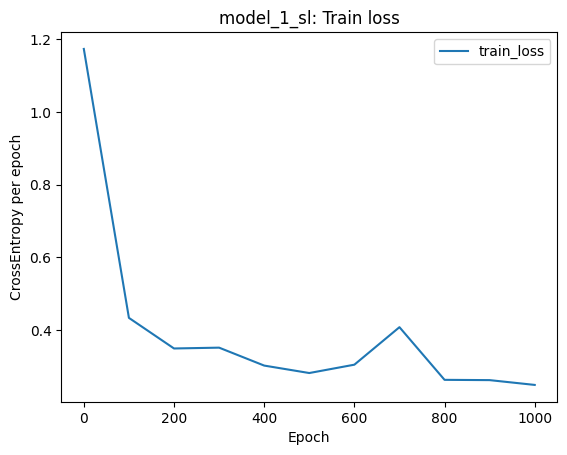

In [ ]:
plot_loss(loss_history=loss,
              epochs= 1000,
              model =  "model_1_sl")


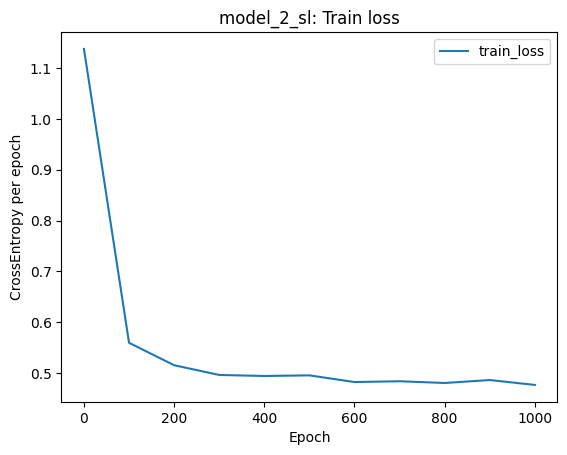

In [ ]:
plot_loss(loss_history=loss2,
              epochs= 1000,
              model =  "model_2_sl")

## Test

In [ ]:
test_acc_1, y_test_1= test(data = data, model = model_1_sl)

Test Accuracy: 0.7959


In [ ]:
test_acc_2, y_test_2= test(data = data, model = model_2_sl)

Test Accuracy: 0.7708


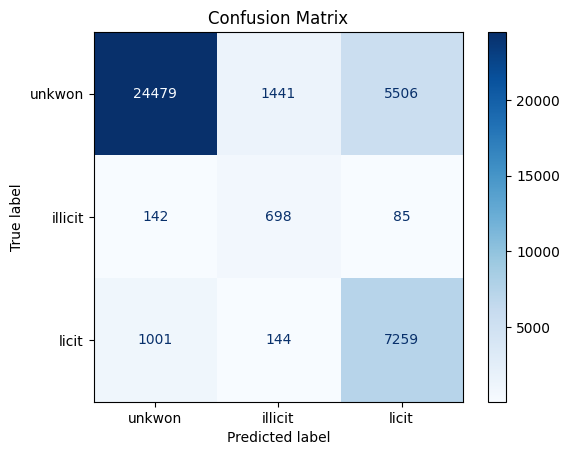

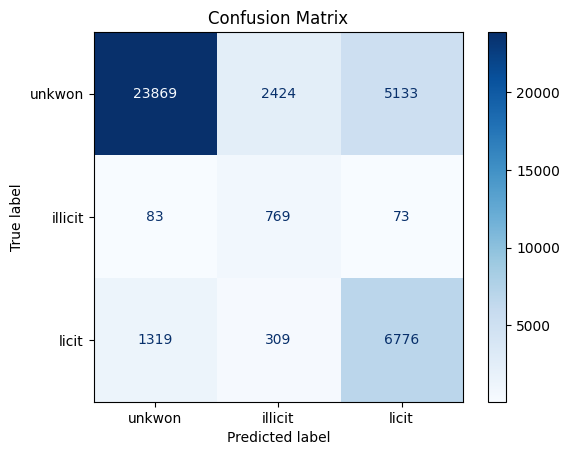

In [ ]:
plot_acc(data, y_test_1)
plot_acc(data, y_test_2)

## Visualize Embeddings

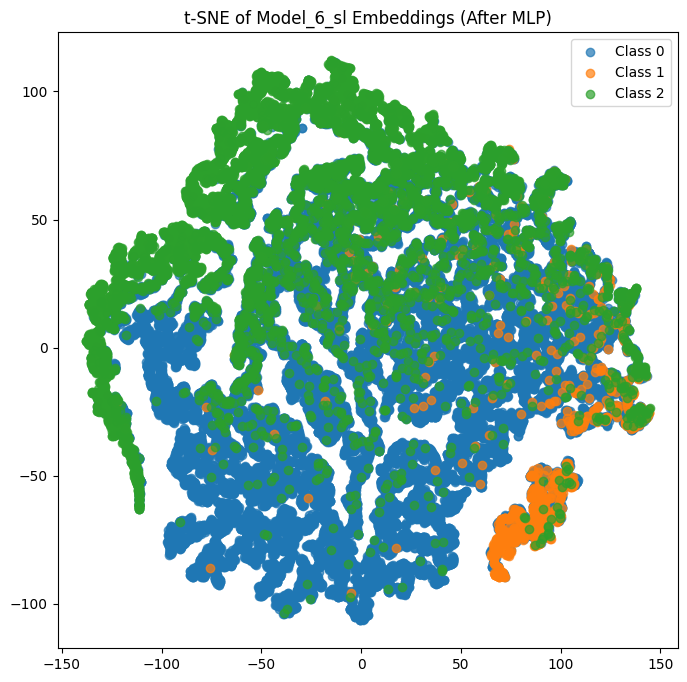

wasserstein distance Matrix:
[[0.         0.52202778 0.48054502]
 [0.52202778 0.         1.        ]
 [0.48054502 1.         0.        ]]


In [ ]:
model_1_sl.eval()

with torch.no_grad():
  test_embeddings_1_sl = model_1_sl.forward(data)[data.test_mask].cpu().numpy()

WS_GNN1_sl = plot_tsne(test_embeddings_1_sl, data.y[data.test_mask].cpu().numpy(), 't-SNE of Model_6_sl Embeddings (After MLP)')
print(f"wasserstein distance Matrix:\n{WS_GNN1_sl/np.max(WS_GNN1_sl)}")

In [ ]:
WS_mean_GNN1_sl=WS_GNN1_sl.mean()

In [ ]:
metrics_1_sl = evaluate_embeddings(test_embeddings_1_sl, data.y[data.test_mask].cpu().numpy())
metrics_1_sl

{'silhouette': 0.07136947, 'knn_accuracy': 0.8558213716108453}

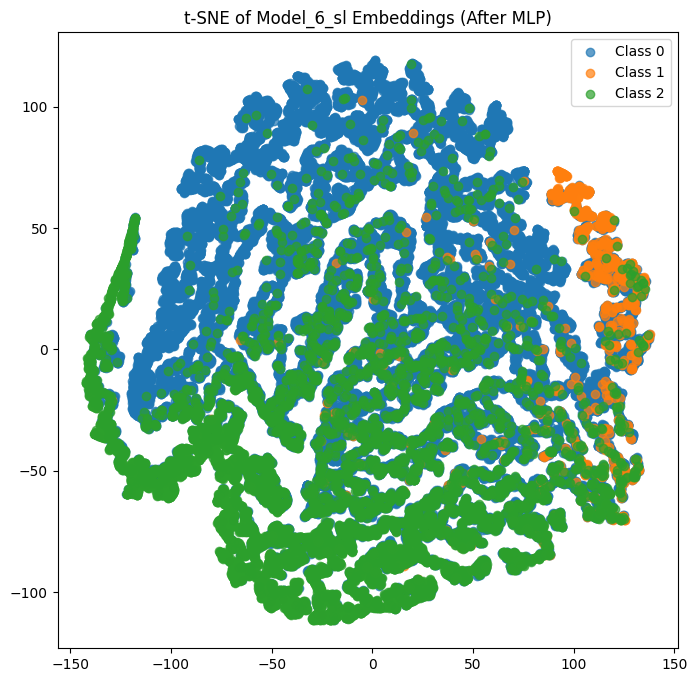

wasserstein distance Matrix:
[[0.         0.55487256 0.50794347]
 [0.55487256 0.         1.        ]
 [0.50794347 1.         0.        ]]


In [ ]:
model_2_sl.eval()

with torch.no_grad():
  test_embeddings_2_sl = model_2_sl.forward(data)[data.test_mask].cpu().numpy()

WS_GNN2_sl = plot_tsne(test_embeddings_2_sl, data.y[data.test_mask].cpu().numpy(), 't-SNE of Model_6_sl Embeddings (After MLP)')
print(f"wasserstein distance Matrix:\n{WS_GNN2_sl/np.max(WS_GNN2_sl)}")

In [ ]:
WS_mean_GNN2_sl=WS_GNN2_sl.mean()

In [ ]:
metrics_2_sl = evaluate_embeddings(test_embeddings_2_sl, data.y[data.test_mask].cpu().numpy())
metrics_2_sl

{'silhouette': 0.08975185, 'knn_accuracy': 0.8370015948963317}

# Residual connections

In [25]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, BatchNorm

class MyMPL2(torch.nn.Module):
  def __init__(self, input_dim, hidden_channels, output_dim):
    super(MyMPL2, self).__init__()

    self.lin1 = torch.nn.Linear(input_dim, hidden_channels)
    self.lin2 = torch.nn.Linear(hidden_channels, output_dim)

  def forward(self, x):
    x = self.lin1(x)
    x = F.relu(x)
    x = self.lin2(x)
    return x

class MyGCN3(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels, n_class,  self_loops = False, is_batch = False):
        super(MyGCN3, self).__init__()
        self.is_batch = is_batch

        # initialize the layers
        self.conv1 = GCNConv(input_dim, hidden_channels, add_self_loops = self_loops)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, add_self_loops = self_loops)
        self.bn1 = BatchNorm(hidden_channels)  # BatchNorm layer
        self.bn2 = BatchNorm(hidden_channels)  # BatchNorm layer
        self.projection = torch.nn.Linear(data.num_features, hidden_channels)
        self.mlp = MyMPL2(hidden_channels, hidden_channels, n_class)

    def forward(self, data, before = False):
        x, edge_index = data.x, data.edge_index
        y = self.projection(x)
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        if self.is_batch:
          x = self.bn1(x)  # Apply BatchNorm after conv1
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x += y  # Residual connection
        y = x

        # Second Message Passing
        x = self.conv2(x, edge_index)
        if self.is_batch:
          x = self.bn2(x)  # Apply BatchNorm after conv1
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x += y  # Residual connection

        if before:
          return x

        # MPL layer
        x = self.mlp(x)

        # Output layer

        return x




## Train

In [26]:
#models = [model_4, model_4_sl, model_5, model_5_sl]
model_4 = MyGCN3(input_dim = data.num_features, hidden_channels=64,n_class=n_classes, is_batch = False).to(device)
model_4_sl = MyGCN3(input_dim = data.num_features, hidden_channels=64, n_class=n_classes,self_loops = True).to(device)
model_5 = MyGCN3(input_dim = data.num_features, hidden_channels=64,n_class=n_classes, is_batch = True).to(device)
model_5_sl = MyGCN3(input_dim = data.num_features, hidden_channels=64,n_class=n_classes, self_loops = True, is_batch = True).to(device)


models = [model_4, model_4_sl, model_5, model_5_sl]
seed = 42
set_seed(seed)

losses = []

for model in models:
  loss = train(epoch=1001,
      data=data,
      model = model,
      lr = .01,
      wd = 5e-4)
  losses.append(loss)


  0%|          | 5/1001 [00:01<04:46,  3.47it/s]

The current loss is 0.7536


 10%|█         | 105/1001 [00:04<00:25, 35.36it/s]

The current loss is 0.0909


 20%|██        | 205/1001 [00:07<00:22, 35.24it/s]

The current loss is 0.0745


 30%|███       | 305/1001 [00:10<00:19, 35.20it/s]

The current loss is 0.0439


 40%|████      | 405/1001 [00:13<00:16, 35.13it/s]

The current loss is 0.0352


 50%|█████     | 505/1001 [00:16<00:14, 35.29it/s]

The current loss is 0.2978


 60%|██████    | 605/1001 [00:18<00:11, 35.28it/s]

The current loss is 0.0407


 70%|███████   | 705/1001 [00:21<00:08, 35.24it/s]

The current loss is 0.0358


 80%|████████  | 805/1001 [00:24<00:05, 35.16it/s]

The current loss is 0.0283


 90%|█████████ | 905/1001 [00:27<00:02, 35.23it/s]

The current loss is 0.0505


100%|██████████| 1001/1001 [00:30<00:00, 33.01it/s]


The current loss is 0.0242


  0%|          | 2/1001 [00:00<00:50, 19.69it/s]

The current loss is 0.9728


 10%|█         | 105/1001 [00:03<00:31, 28.09it/s]

The current loss is 0.1186


 20%|██        | 205/1001 [00:07<00:28, 27.94it/s]

The current loss is 0.0797


 30%|███       | 305/1001 [00:10<00:24, 27.93it/s]

The current loss is 0.0703


 40%|████      | 405/1001 [00:14<00:21, 27.89it/s]

The current loss is 0.0544


 50%|█████     | 505/1001 [00:18<00:17, 27.93it/s]

The current loss is 0.0433


 60%|██████    | 605/1001 [00:21<00:14, 27.87it/s]

The current loss is 0.0509


 70%|███████   | 705/1001 [00:25<00:10, 27.97it/s]

The current loss is 0.0401


 80%|████████  | 805/1001 [00:28<00:07, 27.95it/s]

The current loss is 0.0377


 90%|█████████ | 905/1001 [00:32<00:03, 27.94it/s]

The current loss is 0.0624


100%|██████████| 1001/1001 [00:36<00:00, 27.76it/s]


The current loss is 0.0719


  0%|          | 3/1001 [00:00<00:41, 24.31it/s]

The current loss is 0.7714


 11%|█         | 107/1001 [00:03<00:29, 30.14it/s]

The current loss is 0.1132


 21%|██        | 207/1001 [00:06<00:26, 30.37it/s]

The current loss is 0.0596


 31%|███       | 307/1001 [00:10<00:22, 30.29it/s]

The current loss is 0.0560


 41%|████      | 407/1001 [00:13<00:19, 30.18it/s]

The current loss is 0.0898


 51%|█████     | 507/1001 [00:16<00:16, 30.23it/s]

The current loss is 0.0355


 61%|██████    | 607/1001 [00:20<00:13, 30.28it/s]

The current loss is 0.0313


 71%|███████   | 707/1001 [00:23<00:09, 30.37it/s]

The current loss is 0.0337


 81%|████████  | 807/1001 [00:26<00:06, 30.37it/s]

The current loss is 0.1146


 91%|█████████ | 907/1001 [00:29<00:03, 30.36it/s]

The current loss is 0.0325


100%|██████████| 1001/1001 [00:33<00:00, 30.30it/s]


The current loss is 0.0279


  0%|          | 3/1001 [00:00<00:34, 29.14it/s]

The current loss is 0.7481


 10%|█         | 105/1001 [00:04<00:36, 24.80it/s]

The current loss is 0.1081


 20%|██        | 204/1001 [00:08<00:31, 25.12it/s]

The current loss is 0.0601


 31%|███       | 306/1001 [00:12<00:27, 24.91it/s]

The current loss is 0.0723


 40%|████      | 405/1001 [00:16<00:23, 24.86it/s]

The current loss is 0.0542


 50%|█████     | 504/1001 [00:20<00:19, 25.24it/s]

The current loss is 0.0345


 61%|██████    | 606/1001 [00:24<00:15, 24.74it/s]

The current loss is 0.0375


 70%|███████   | 705/1001 [00:28<00:11, 24.76it/s]

The current loss is 0.1276


 80%|████████  | 804/1001 [00:32<00:07, 25.13it/s]

The current loss is 0.0763


 91%|█████████ | 906/1001 [00:36<00:03, 24.89it/s]

The current loss is 0.0568


100%|██████████| 1001/1001 [00:40<00:00, 24.87it/s]

The current loss is 0.0498


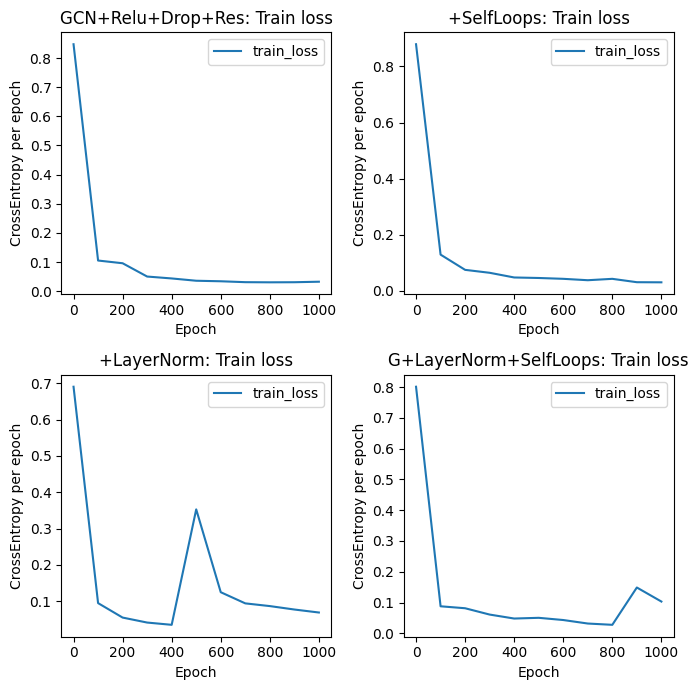

In [ ]:
titles = ["GCN+Relu+Drop+Res", "+SelfLoops", "+LayerNorm", "G+LayerNorm+SelfLoops", ]

fig, ax =  plt.subplots(2,2,figsize=(7, 7))
ax = ax.flatten()

for i in range(len(models)):
  plot_loss(ax = ax[i],
            loss_history=losses[i],
              epochs= 1000,
              model =  titles[i])
plt.tight_layout()
plt.show()

## test

In [27]:
GCNS_accurancies = []
GCNS_preds = []
GCNS_aucss = []

for model in models:
  test_acc, y_test, auc= test(data = data, model = model, bin = True)
  GCNS_accurancies.append(test_acc)
  GCNS_preds.append(y_test)
  GCNS_aucss.append(auc)


Test Accuracy: 0.9729
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       435
           1       0.99      0.98      0.98      4222

    accuracy                           0.97      4657
   macro avg       0.91      0.94      0.92      4657
weighted avg       0.97      0.97      0.97      4657

Test Accuracy: 0.9734
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       435
           1       0.99      0.98      0.99      4222

    accuracy                           0.97      4657
   macro avg       0.91      0.95      0.92      4657
weighted avg       0.98      0.97      0.97      4657

Test Accuracy: 0.9723
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       435
           1       0.99      0.98      0.98      4222

    accuracy                           0.97      4657
   macro avg       0.90      0.94      0.92      4657
weighted

GCN+Relu+Drop+Res accuracy of: 0.9495383293966072
GCN+Relu+Drop+Res  auc: 0.9443326418268837
+SelfLoops accuracy of: 0.9791711402190251
+SelfLoops  auc: 0.9503656272290193
+LayerNorm accuracy of: 0.9602748550569036
+LayerNorm  auc: 0.9389130280904077
G+LayerNorm+SelfLoops accuracy of: 0.9463173716985184
G+LayerNorm+SelfLoops  auc: 0.9332772505267973


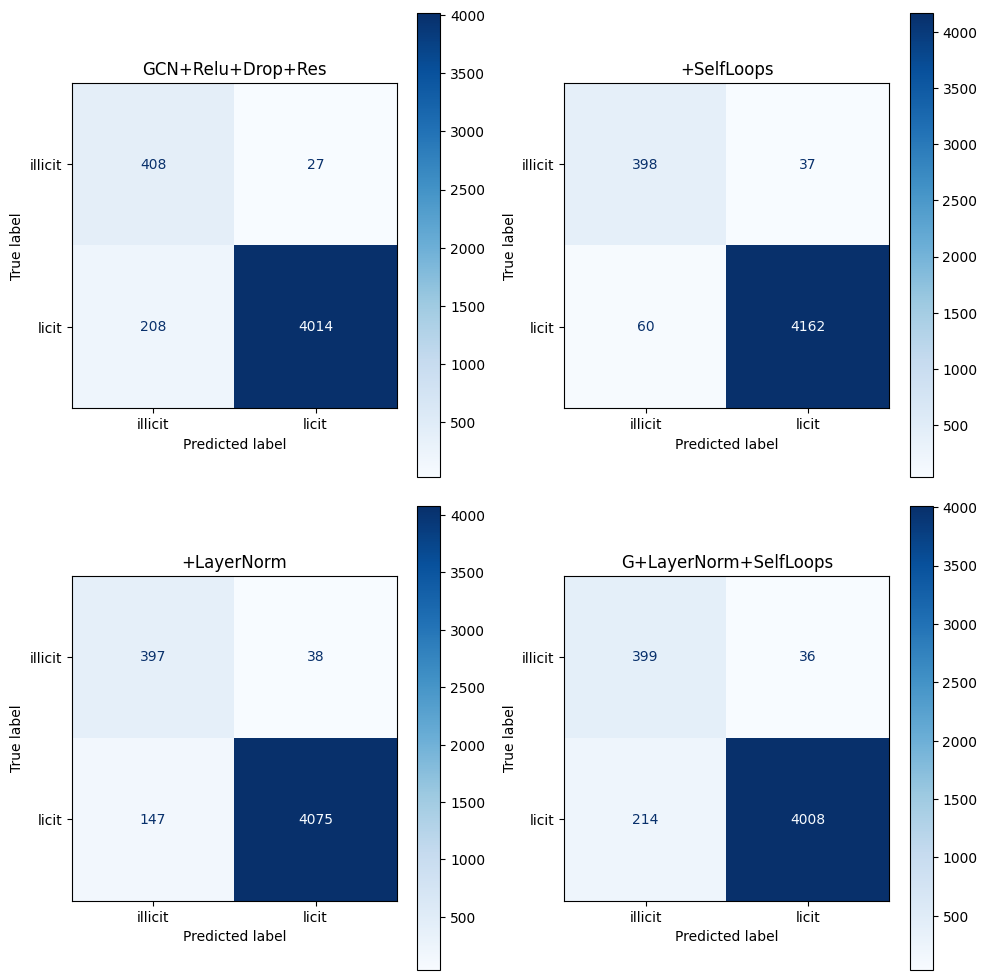

In [ ]:
fig, ax =  plt.subplots(2,2,figsize=(10, 10))
ax = ax.flatten()

for i in range(len(models)):
  print(f"{titles[i]} accuracy of: {GCNS_accurancies[i]}")
  print(f"{titles[i]}  auc: {GCNS_aucss[i]}")
  plot_acc(ax=ax[i], data=data, labels=GCNS_preds[i], bin=True, title=titles[i])


plt.tight_layout()
plt.show()


## Visualize Embeddings

In [35]:
embeddings_res = []
WS_residuals = []

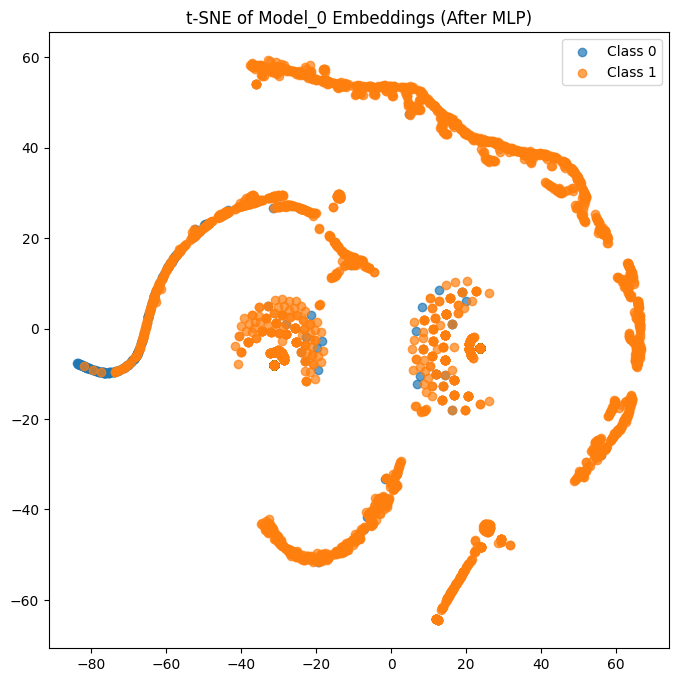

wasserstein distance Matrix for model_res_1 :
[[0. 1.]
 [1. 0.]]


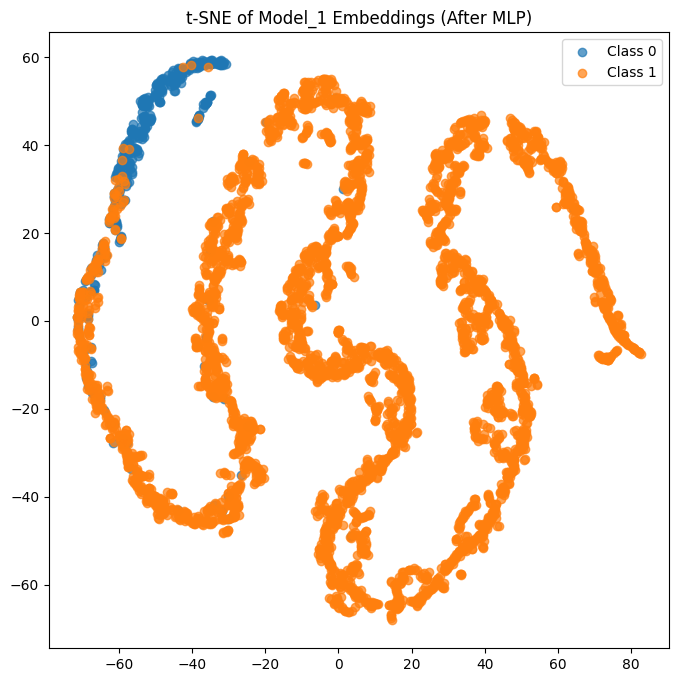

wasserstein distance Matrix for model_res_2 :
[[0. 1.]
 [1. 0.]]


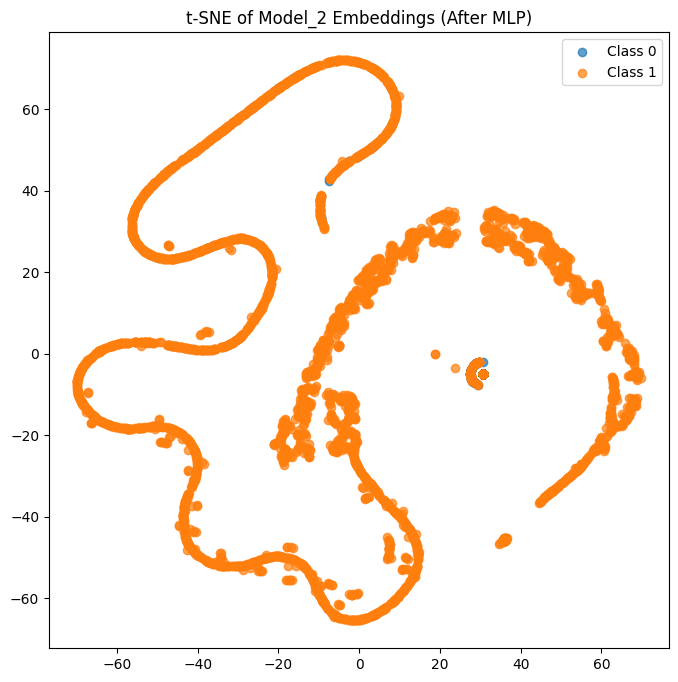

wasserstein distance Matrix for model_res_3 :
[[0. 1.]
 [1. 0.]]


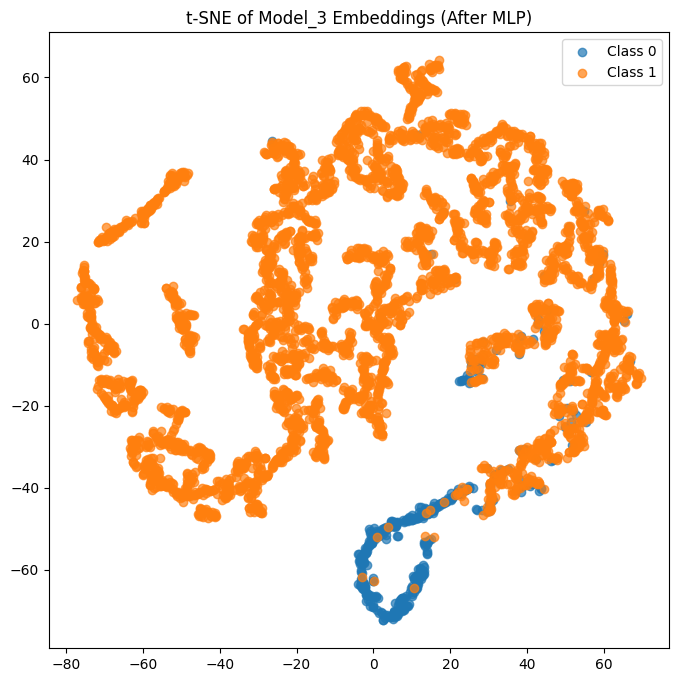

wasserstein distance Matrix for model_res_4 :
[[0. 1.]
 [1. 0.]]


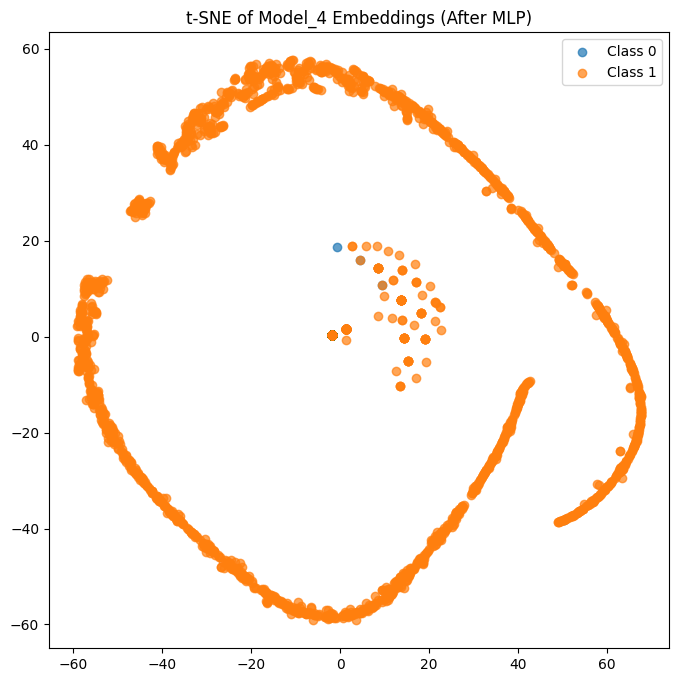

wasserstein distance Matrix for model_res_5 :
[[0. 1.]
 [1. 0.]]


In [36]:

m = models[1]
for model in models:
  model.eval()
  with torch.no_grad():
    test_embeddings_i = model.forward(data)[data.test_mask].cpu().numpy()
  embeddings_res.append(test_embeddings_i)

for i in range(len(embeddings_res)):
  WS_res=plot_tsne(embeddings_res[i], data.y[data.test_mask].cpu().numpy(), f't-SNE of Model_{i} Embeddings (After MLP)')
  print(f"wasserstein distance Matrix for model_res_{i+1} :\n{WS_res/np.max(WS_res)}")
  WS_residuals.append(WS_res)

In [37]:
ws_mean_res = []

for i, w in enumerate(WS_residuals):
  ws_mean = w.mean()
  ws_mean_res.append(ws_mean)
  print(f"WS mean for model_{i+1}: {ws_mean}")


WS mean for model_1: 11.878621647429728
WS mean for model_2: 23.663669432428165
WS mean for model_3: 14.022359888005067
WS mean for model_4: 18.69984317343049
WS mean for model_5: 7.836220320788556


In [38]:
ws_res_metrix = []

for i, emb in enumerate(embeddings_res):
  emb_metric = evaluate_embeddings(embeddings_res[i], data.y[data.test_mask].cpu().numpy())
  ws_res_metrix.append(emb_metric)
  print(f"WS mean for model_{i+1}: {emb_metric}")

WS mean for model_1: {'silhouette': -0.023366766, 'knn_accuracy': 0.9147538527495932}
WS mean for model_2: {'silhouette': 0.28492585, 'knn_accuracy': 0.9613503409043762}
WS mean for model_3: {'silhouette': -0.6175591, 'knn_accuracy': 0.9065922009192201}
WS mean for model_4: {'silhouette': -0.25612956, 'knn_accuracy': 0.9705798831843555}
WS mean for model_5: {'silhouette': -0.56788784, 'knn_accuracy': 0.9065922009192201}


# GAT

In [29]:
from torch_geometric.nn import GATConv
from torch_geometric.nn import BatchNorm
import torch
import torch.nn.functional as F

class MyGAT(torch.nn.Module):
    def __init__(self, input_features, hidden_channels, n_heads, num_classes, dropout, self_loops=False, self_res=False, is_batch=False):
        super(MyGAT, self).__init__()

        self.dropout = dropout
        self.out_head = hidden_channels
        self.self_res = self_res
        self.is_batch = is_batch

        # Define GAT layers
        self.conv1 = GATConv(input_features, hidden_channels, heads=n_heads, dropout=dropout, add_self_loops=self_loops)
        self.conv2 = GATConv(hidden_channels * n_heads, hidden_channels, heads=n_heads, dropout=dropout, add_self_loops=self_loops, concat=False)

        # Define MLP for output prediction
        self.mlp = MyMPL2(hidden_channels, self.out_head, num_classes)

        # Define projection layer for residual connection if self_res is True
        if self_res:
            self.projection = torch.nn.Linear(input_features, hidden_channels * n_heads)
            self.projection2 = torch.nn.Linear( hidden_channels * n_heads, hidden_channels)


        # Define batch normalization layers if is_batch is True
        if is_batch:
            self.bn1 = BatchNorm(hidden_channels * n_heads)
            self.bn2 = BatchNorm(hidden_channels)

    def forward(self, data, before=False):
        x, edge_index = data.x, data.edge_index

        # Handle residual connection if self_res is True
        if self.self_res:
            y = self.projection(x)  # Apply the projection layer

        # Apply the first GATConv layer
        x = self.conv1(x, edge_index)
        if self.is_batch:
            x = self.bn1(x)  # Apply BatchNorm after conv1
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Add residual connection if self_res is True
        if self.self_res:
            x = x+  y
            y = self.projection2(x)

        # Apply the second GATConv layer
        x = self.conv2(x, edge_index)
        if self.is_batch:
            x = self.bn2(x)  # Apply BatchNorm after conv2
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Add residual connection again if self_res is True
        if self.self_res:
            x += y

        if before:
            return x

        # Apply MLP for the final output layer
        x = self.mlp(x)

        return x


In [30]:
model_6 = MyGAT(input_features= data.num_features, hidden_channels=64, n_heads=8, num_classes = 2, dropout= 0.5).to(device)
model_6_sl = MyGAT(input_features= data.num_features, hidden_channels=64, n_heads=8, num_classes = 2, dropout= 0.5, self_loops= True).to(device)
model_6_sr = MyGAT(input_features= data.num_features, hidden_channels=64, n_heads=8, num_classes = 2, dropout= 0.5, self_loops= True, self_res=True).to(device)
model_6_tt = MyGAT(input_features= data.num_features, hidden_channels=64, n_heads=8, num_classes = 2, dropout= 0.5, self_loops= True, self_res=True, is_batch = True).to(device)
model_6_sb = MyGAT(input_features= data.num_features, hidden_channels=64, n_heads=8, num_classes = 2, dropout= 0.5, self_loops= False, self_res=True, is_batch = True).to(device)





## Train

In [ ]:
models = [model_6,model_6_sl, model_6_sr, model_6_tt, model_6_sb]
seed = 42
set_seed(seed)

GATS_losses = []

for model in models:
  loss = train(epoch=1001,
      data=data,
      model = model,
      lr = .01,
      wd = 5e-4)
  GATS_losses.append(loss)


  0%|          | 2/1001 [00:00<03:41,  4.51it/s]

The current loss is 0.7050


 10%|█         | 102/1001 [00:26<03:45,  3.98it/s]

The current loss is 0.5172


 20%|██        | 202/1001 [00:53<03:24,  3.91it/s]

The current loss is 0.5152


 30%|███       | 302/1001 [01:20<03:01,  3.86it/s]

The current loss is 0.5155


 40%|████      | 402/1001 [01:48<02:33,  3.90it/s]

The current loss is 0.5168


 50%|█████     | 502/1001 [02:15<02:07,  3.90it/s]

The current loss is 0.5138


 60%|██████    | 602/1001 [02:42<01:42,  3.88it/s]

The current loss is 0.5163


 70%|███████   | 702/1001 [03:09<01:17,  3.88it/s]

The current loss is 0.5097


 80%|████████  | 802/1001 [03:36<00:51,  3.88it/s]

The current loss is 0.5130


 90%|█████████ | 902/1001 [04:03<00:25,  3.89it/s]

The current loss is 0.5137


100%|██████████| 1001/1001 [04:30<00:00,  3.70it/s]


The current loss is 0.5106


  0%|          | 2/1001 [00:00<03:43,  4.48it/s]

The current loss is 0.7083


 10%|█         | 102/1001 [00:34<04:52,  3.07it/s]

The current loss is 0.1910


 20%|██        | 202/1001 [01:09<04:19,  3.08it/s]

The current loss is 0.1731


 30%|███       | 302/1001 [01:43<03:47,  3.08it/s]

The current loss is 0.1713


 40%|████      | 402/1001 [02:17<03:14,  3.08it/s]

The current loss is 0.1673


 50%|█████     | 502/1001 [02:52<02:42,  3.07it/s]

The current loss is 0.1599


 60%|██████    | 602/1001 [03:26<02:09,  3.08it/s]

The current loss is 0.1608


 70%|███████   | 702/1001 [04:00<01:37,  3.07it/s]

The current loss is 0.1662


 80%|████████  | 802/1001 [04:34<01:04,  3.08it/s]

The current loss is 0.2284


 90%|█████████ | 902/1001 [05:09<00:32,  3.07it/s]

The current loss is 0.1831


100%|██████████| 1001/1001 [05:43<00:00,  2.91it/s]


The current loss is 0.1816


  0%|          | 2/1001 [00:00<04:14,  3.93it/s]

The current loss is 0.7780


 10%|█         | 102/1001 [00:39<05:31,  2.71it/s]

The current loss is 0.1651


 20%|██        | 202/1001 [01:18<04:54,  2.72it/s]

The current loss is 0.1295


 30%|███       | 302/1001 [01:57<04:17,  2.71it/s]

The current loss is 0.1117


 40%|████      | 402/1001 [02:35<03:40,  2.72it/s]

The current loss is 0.0927


 50%|█████     | 502/1001 [03:14<03:03,  2.72it/s]

The current loss is 0.0877


 60%|██████    | 602/1001 [03:53<02:26,  2.72it/s]

The current loss is 0.0842


 70%|███████   | 702/1001 [04:32<01:50,  2.72it/s]

The current loss is 0.0972


 80%|████████  | 802/1001 [05:10<01:12,  2.74it/s]

The current loss is 0.4900


 90%|█████████ | 902/1001 [05:49<00:36,  2.74it/s]

The current loss is 0.4422


100%|██████████| 1001/1001 [06:27<00:00,  2.58it/s]


The current loss is 0.3251


  0%|          | 2/1001 [00:00<04:28,  3.72it/s]

The current loss is 0.6954


 10%|█         | 102/1001 [00:41<05:54,  2.54it/s]

The current loss is 0.1707


 20%|██        | 202/1001 [01:23<05:14,  2.54it/s]

The current loss is 0.1017


 30%|███       | 302/1001 [02:04<04:33,  2.55it/s]

The current loss is 0.2871


 40%|████      | 402/1001 [02:46<03:55,  2.54it/s]

The current loss is 0.1740


 50%|█████     | 502/1001 [03:27<03:16,  2.54it/s]

The current loss is 0.1959


 60%|██████    | 602/1001 [04:09<02:36,  2.55it/s]

The current loss is 0.1854


 70%|███████   | 702/1001 [04:50<01:57,  2.55it/s]

The current loss is 0.1249


 80%|████████  | 802/1001 [05:32<01:18,  2.55it/s]

The current loss is 0.1294


 90%|█████████ | 902/1001 [06:13<00:38,  2.55it/s]

The current loss is 0.1151


100%|██████████| 1001/1001 [06:54<00:00,  2.41it/s]


The current loss is 0.1272


  0%|          | 2/1001 [00:00<03:39,  4.56it/s]

The current loss is 0.7712


 10%|█         | 102/1001 [00:34<04:49,  3.11it/s]

The current loss is 0.1363


 12%|█▏        | 122/1001 [00:41<04:57,  2.95it/s]

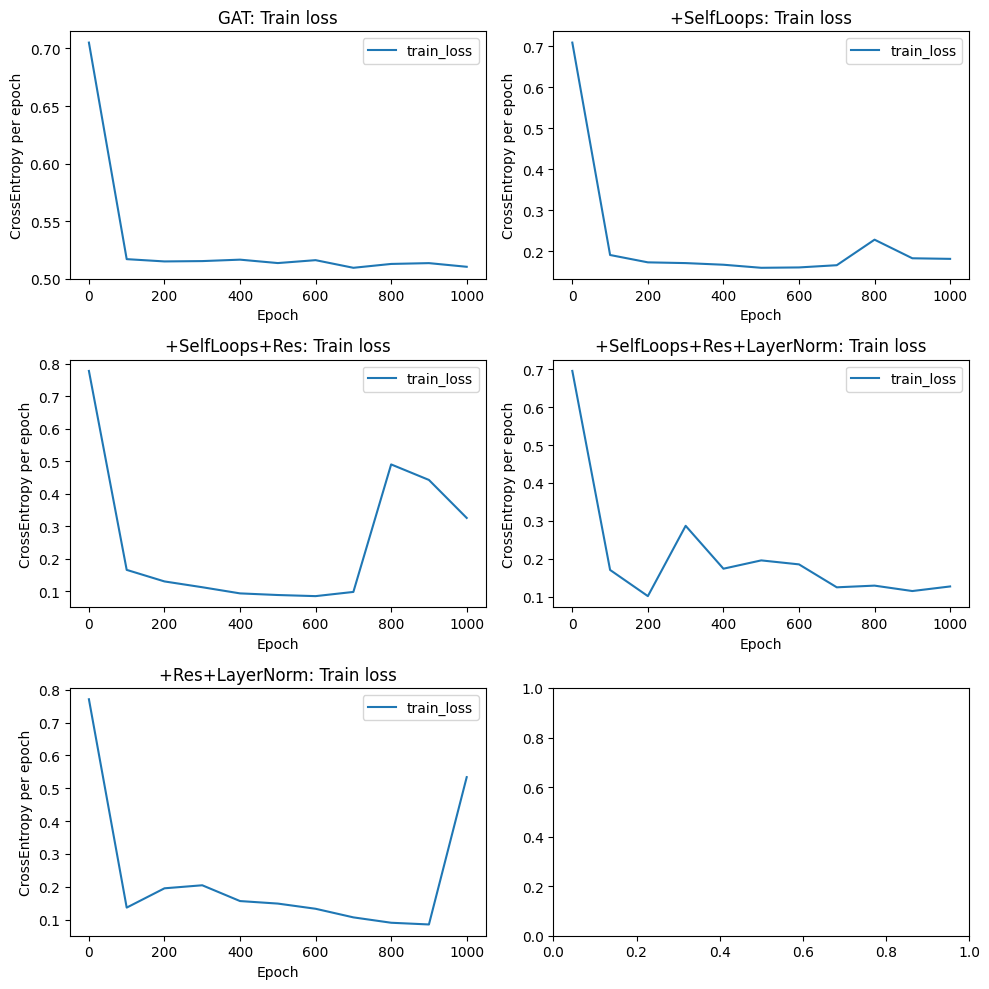

In [32]:
titles = ["GAT",
          "+SelfLoops",
          "+SelfLoops+Res",
          "+SelfLoops+Res+LayerNorm",
          "+Res+LayerNorm",
          ]

fig, ax = plt.subplots(3, 2, figsize=(10, 10))
ax = ax.flatten()

for i in range(len(models)):
    # If i is less than 4, assign each model to a specific subplot axis.
    if i < 4:
        plot_loss(loss_history=GATS_losses[i],
                  epochs=1000,
                  model=titles[i],
                  ax=ax[i])
    else:
        # For the 5th and 6th model, assign them to the last row (row 2) of the subplots
        plot_loss(loss_history=GATS_losses[i],
                  epochs=1000,
                  model=titles[i],
                  ax=ax[4])  # Only the last row, all columns

plt.tight_layout()
plt.show()


## Test

In [33]:
GATS_accurancies = []
GATS_preds = []
GATS_aucss = []

for model in models:
  test_acc, y_test, accs= test(data = data, model = model, bin = True)
  GATS_accurancies.append(test_acc)
  GATS_preds.append(y_test)
  GATS_aucss.append(accs)

Test Accuracy: 0.7095
              precision    recall  f1-score   support

           0       0.20      0.69      0.31       435
           1       0.96      0.71      0.82      4222

    accuracy                           0.71      4657
   macro avg       0.58      0.70      0.56      4657
weighted avg       0.89      0.71      0.77      4657

Test Accuracy: 0.9571
              precision    recall  f1-score   support

           0       0.72      0.89      0.79       435
           1       0.99      0.96      0.98      4222

    accuracy                           0.96      4657
   macro avg       0.85      0.93      0.89      4657
weighted avg       0.96      0.96      0.96      4657

Test Accuracy: 0.7747
              precision    recall  f1-score   support

           0       0.29      0.97      0.45       435
           1       1.00      0.75      0.86      4222

    accuracy                           0.77      4657
   macro avg       0.64      0.86      0.65      4657
weighted

Model_0 accieved accuracy of: 0.7131200343568821
Model_0 auc: 0.7025964161453144
Model_1 accieved accuracy of: 0.950397251449431
Model_1 auc: 0.938620362959212
Model_2 accieved accuracy of: 0.7388876959415933
Model_2 auc: 0.8394964526263633
Model_3 accieved accuracy of: 0.9188318660081598
Model_3 auc: 0.9047155839418044
Model_4 accieved accuracy of: 0.9375134206570753
Model_4 auc: 0.9346077198255442


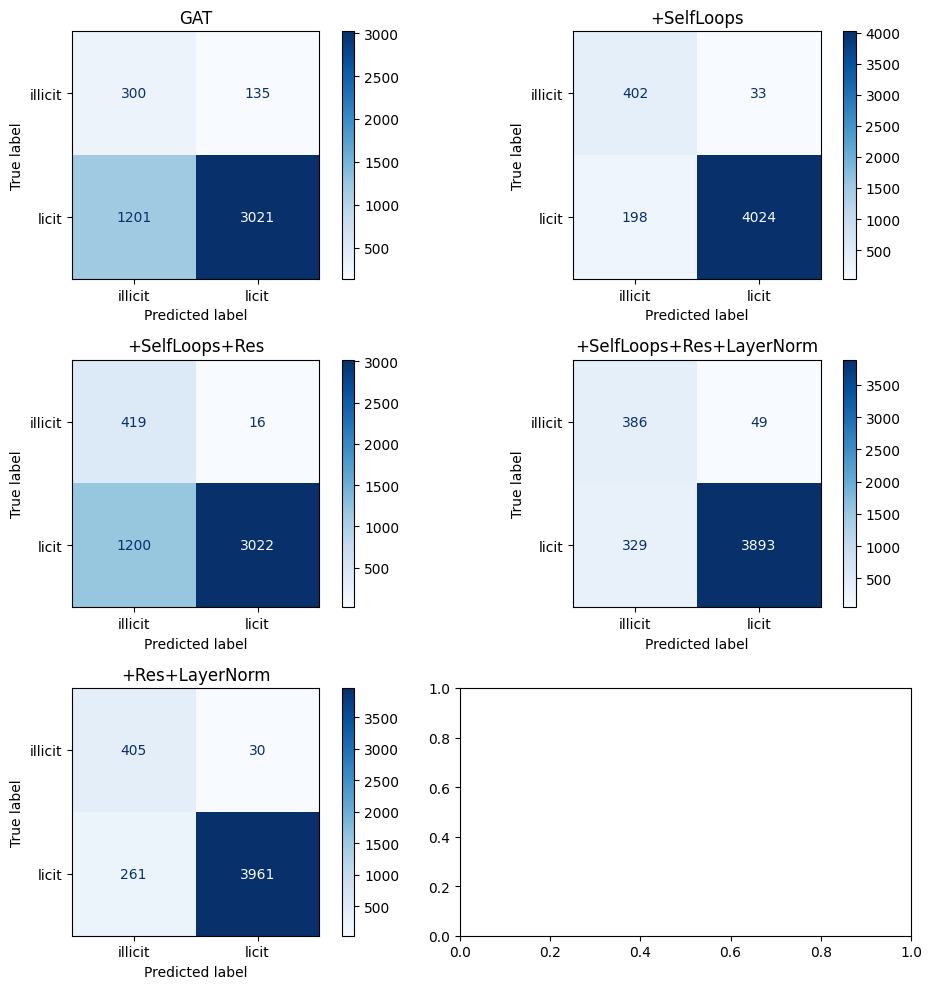

In [ ]:
fig, ax = plt.subplots(3,2,figsize =(10,10))
ax = ax.flatten()

for i in range(len(models)):
  print(f"Model_{i} accieved accuracy of: {GATS_accurancies[i]}")
  print(f"Model_{i} auc: {GATS_aucss[i]}")
  plot_acc(ax = ax[i], data= data, labels = GATS_preds[i], bin = True, title = titles[i])

plt.tight_layout()
plt.show()

## Visualize Embeddings

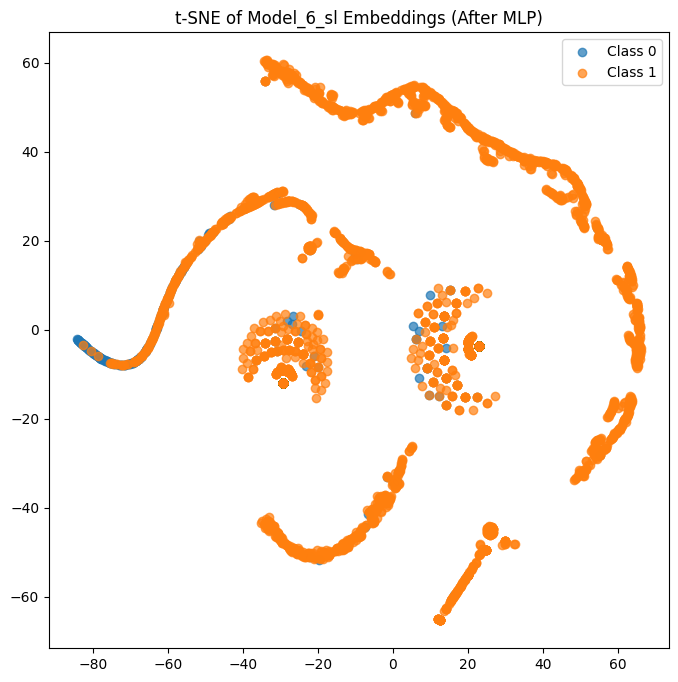

wasserstein distance Matrix:
[[0. 1.]
 [1. 0.]]


In [34]:
model_6.eval()

with torch.no_grad():
  test_embeddings_6 = model_6.forward(data)[data.test_mask].cpu().numpy()

WS_Gat = plot_tsne(test_embeddings_6, data.y[data.test_mask].cpu().numpy(), 't-SNE of Model_6_sl Embeddings (After MLP)')
print(f"wasserstein distance Matrix:\n{WS_Gat/np.max(WS_Gat)}")

In [ ]:
WS_mean_Gat= WS_Gat.mean()

In [ ]:
metrics_6 = evaluate_embeddings(test_embeddings_6, data.y[data.test_mask].cpu().numpy())
metrics_6

{'silhouette': -0.1329657, 'knn_accuracy': 0.7342902711323764}

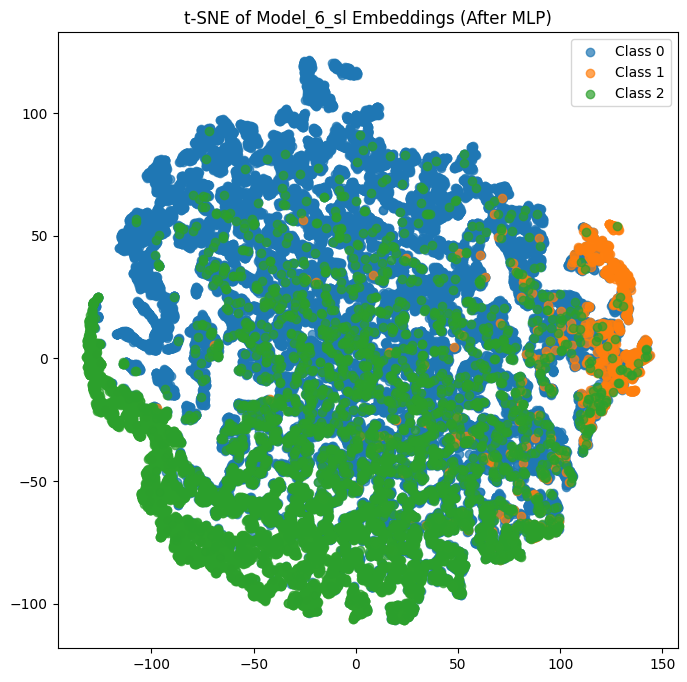

wasserstein distance Matrix:
[[0.         0.58689806 0.49296019]
 [0.58689806 0.         1.        ]
 [0.49296019 1.         0.        ]]


In [ ]:
model_6_sl.eval()

with torch.no_grad():
  test_embeddings_6_sl = model_6_sl.forward(data)[data.test_mask].cpu().numpy()

WS_Gat_sl = plot_tsne(test_embeddings_6_sl, data.y[data.test_mask].cpu().numpy(), 't-SNE of Model_6_sl Embeddings (After MLP)')
print(f"wasserstein distance Matrix:\n{WS_Gat_sl/np.max(WS_Gat_sl)}")

In [ ]:
WS_mean_Gat_sl = WS_Gat_sl.mean()

In [ ]:
metrics_6_sl = evaluate_embeddings(test_embeddings_6_sl, data.y[data.test_mask].cpu().numpy())
metrics_6_sl

{'silhouette': 0.14549139, 'knn_accuracy': 0.8632069684701262}

# MultiLayer GAT

In [ ]:
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool, BatchNorm



class DeepGAT(torch.nn.Module):
    def __init__(self, in_channels, out, n_heads, n_layers, concat, num_classes, dropout, is_batch = False):
        super(DeepGAT, self).__init__()

        self.n_layers = n_layers
        self.dropout = dropout
        self.is_batch = is_batch

        # Calculate input sizes for each layer
        self.gat_layers = torch.nn.ModuleList(
            [GATConv(
            in_channels= in_channels if i == 0 else out*n_heads[i],
            out_channels= out ,
            heads=n_heads[i],
            dropout=dropout,
            concat=concat[i],
            add_self_loops = True
        )
             for i in range(n_layers)]
        )


        # Layer normalization
        self.layer_norm = torch.nn.ModuleList([
            torch.nn.LayerNorm(out * n_heads[i] if concat[i] else out)
            for i in range(n_layers)
        ])

        self.out_channels = [out * n_heads[i] if concat[i] else out for i in range(n_layers)]

         # Residual connection projection (if needed)
        self.residual_proj = torch.nn.ModuleList(
            [
              torch.nn.Linear(in_channels if i == 0 else (out * n_heads[i - 1] if concat[i - 1] else out),
                              self.out_channels[i])
    for i in range(n_layers)
])




        self.ff = torch.nn.ModuleList([
            torch.nn.Sequential(
                torch.nn.Linear(out * n_heads[i] if concat[i] else out, out),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout),
                torch.nn.Linear(out, out * n_heads[i] if concat[i] else out)
            )
            for i in range(n_layers)
        ])


        # Final classification layer
        self.classifier = torch.nn.Linear(out, num_classes)

    def forward(self, data, ret = False):
      x, edge_index = data.x, data.edge_index

      for i in range(self.n_layers):
          #print(i)
          # Residual connection
          res = x
          if (i ==0) or (i == self.n_layers-1):
              res = self.residual_proj[i](res)
         # print(res.shape)

          x = self.gat_layers[i](x, edge_index)
          #print(x.shape)
          x = x + res
          if self.is_batch:
            x = self.layer_norm[i](x)

          #print(x.shape)
          x = x + self.ff[i](x)
          #x = self.ff[i](x)  # Apply the feed-forward layer

      if ret:
        #print(x.shape)
        return x
      # Final classification
      x = self.classifier(x)

      return F.softmax(x, dim=1)



## Train

In [ ]:
seed = 42
set_seed(seed)
model_7 = DeepGAT(in_channels = data.num_features,
                  out = 64,
                  n_heads = [8,8,8],
                  n_layers=3,
                  concat= [True, True, False],
                  num_classes = 2,
                  dropout=0.5,
                  is_batch = True).to(device)


MultiGat_loss = train(epoch=1001,
      data=data,
      model = model_7,
      lr = .01,
      wd = 5e-4)


  0%|          | 1/1001 [00:00<11:55,  1.40it/s]

The current loss is 0.7109


 10%|█         | 101/1001 [01:08<11:56,  1.26it/s]

The current loss is 0.4071


 20%|██        | 201/1001 [02:16<10:41,  1.25it/s]

The current loss is 0.3885


 30%|███       | 301/1001 [03:24<09:20,  1.25it/s]

The current loss is 0.3862


 40%|████      | 401/1001 [04:32<08:00,  1.25it/s]

The current loss is 0.3682


 50%|█████     | 501/1001 [05:40<06:40,  1.25it/s]

The current loss is 0.3653


 60%|██████    | 601/1001 [06:48<05:19,  1.25it/s]

The current loss is 0.3625


 70%|███████   | 701/1001 [07:56<04:00,  1.25it/s]

The current loss is 0.3590


 80%|████████  | 801/1001 [09:04<02:40,  1.25it/s]

The current loss is 0.3605


 90%|█████████ | 901/1001 [10:12<01:20,  1.25it/s]

The current loss is 0.3592


100%|██████████| 1001/1001 [11:20<00:00,  1.47it/s]

The current loss is 0.3581


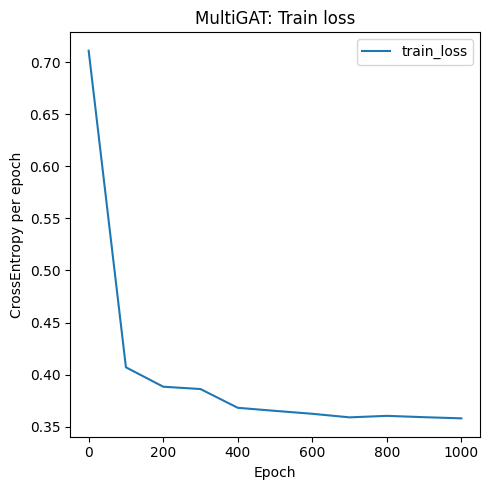

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5, 5))
plot_loss(loss_history=MultiGat_loss,
              epochs= 1000,
              model =  "MultiGAT",
          ax = ax)
plt.tight_layout()
plt.show()

## Test

In [ ]:
MultiGAT_test_acc, MultiGAT_y_test, MultiGAT_auc= test(data = data, model = model_7, bin = True)

Test Accuracy: 0.9624
              precision    recall  f1-score   support

           0       0.76      0.88      0.81       435
           1       0.99      0.97      0.98      4222

    accuracy                           0.96      4657
   macro avg       0.87      0.93      0.90      4657
weighted avg       0.97      0.96      0.96      4657



In [ ]:
print(f"MultiGAT accuracy of: {MultiGAT_test_acc:.2f}")
print(f"MultiGAT auc: {MultiGAT_auc:.2f}")

MultiGAT accuracy of: 0.96
MultiGAT auc: 0.93


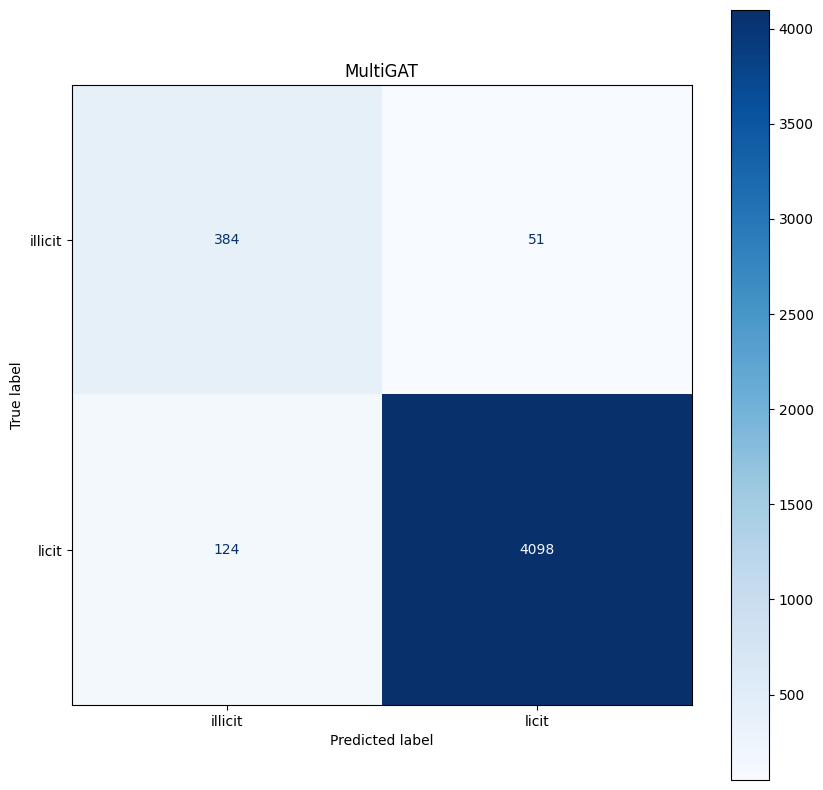

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10, 10))

plot_acc(ax =ax, data = data, labels = MultiGAT_y_test, bin = True, title = "MultiGAT")


## Visualize Embeddings

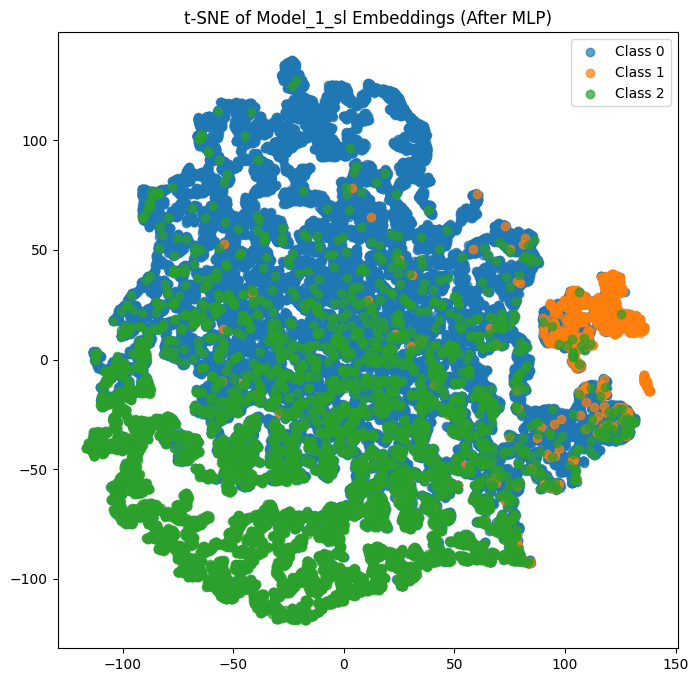

wasserstein distance Matrix:
[[  0.          63.98546124  56.91284803]
 [ 63.98546124   0.         103.57282943]
 [ 56.91284803 103.57282943   0.        ]]


In [ ]:
model_7.eval()

with torch.no_grad():
  test_embeddings_7 = model_7.forward(data)[data.test_mask].cpu().numpy()

WS_DeepGat = plot_tsne(test_embeddings_7, data.y[data.test_mask].cpu().numpy(), 't-SNE of Model_1_sl Embeddings (After MLP)')
print(f"wasserstein distance Matrix:\n{WS_DeepGat/np.max(WS_DeepGat)}")

In [ ]:
WS_mean_DeepGat= WS_DeepGat.mean()

In [ ]:
metrics = evaluate_embeddings(test_embeddings_7, data.y[data.test_mask].cpu().numpy())
metrics

{'silhouette': 0.27846748, 'knn_accuracy': 0.8853392221813274}

# Compare every models' embeddings and choose the best one

In [ ]:
# Define mean_ws by combining the initial values with those from ws_mean_res
mean_ws = [WS_mean_DeepGat, WS_mean_Gat, WS_mean_Gat_sl, WS_mean_GNN1, WS_mean_GNN2, WS_mean_GNN1_sl, WS_mean_GNN2_sl]
mean_ws.extend(ws_mean_res)  # Use extend instead of append for adding elements from a list

# Define metrics_ls by combining the initial values with those from ws_res_metrix
metrics_ls = [metrics, metrics_6, metrics_6_sl, metrics_1, metrics_2, metrics_1_sl, metrics_2_sl]
metrics_ls.extend(ws_res_metrix)  # Use extend instead of append for adding elements from a list

# Initialize empty lists for silhouette and knn_accuracy
silhouette_ls = []
knn_accuracy_ls = []

# Extract silhouette and knn_accuracy values from metrics_ls
for d in metrics_ls:
    for k, v in d.items():
        if k == "silhouette":
            silhouette_ls.append(v)
        else:
            knn_accuracy_ls.append(v)

# Define the model names
models_ls = ["model_7", "model_6", "model_6_sl", "model_1", "model_2", "model_1_sl", "model_2_sl","model_4", "model_4_sl", "model_5", "model_5_sl" ]

# Create the evaluation dictionary
eval_dict = {
    "mean_ws": mean_ws,
    "silhouette": silhouette_ls,
    "knn_accuracy": knn_accuracy_ls
}

eval_df = pd.DataFrame(eval_dict, index = models_ls)
eval_df

mean_ws  silhouette  knn_accuracy
model_7     49.882475    0.278467      0.885339
model_6     11.216800   -0.132966      0.734290
model_6_sl  47.593750    0.145491      0.863207
model_1     11.172521   -0.346396      0.623727
model_2      9.061824   -0.405472      0.652214
model_1_sl  45.679086    0.071369      0.855821
model_2_sl  44.620579    0.089752      0.837002
model_4     48.916421    0.064473      0.897141
model_4_sl  49.327320    0.023623      0.898736
model_5     46.692868    0.061925      0.899301
model_5_sl  49.972494    0.068511      0.895375

In [ ]:
eval_df.to_csv('eval_results_tot.csv', index=True)

# GraphSMOTE

## Syntetic node extractor

In [ ]:
import torch_geometric.transforms as T
# Initial link split
transform = T.RandomLinkSplit(
        num_val=0.1,
        num_test=0.2,
        is_undirected=True,
        add_negative_train_samples=False
    )

train_data, val_data, test_data = transform(data)
train_data

Data(x=[203769, 166], edge_index=[2, 173132], y=[203769], train_mask=[203769], val_mask=[203769], test_mask=[203769], edge_label=[86566], edge_label_index=[2, 86566])

In [ ]:
import torch
import numpy as np
from scipy.spatial.distance import pdist, squareform
import random

def src_smote(features, labels, idx_train, portion=1.0, im_class_num=1):
    """
    Implementation of SMOTE for graph data with PyTorch tensors.

    Args:
        features: Node feature matrix
        labels: Node labels
        idx_train: Training indices
        portion: Oversampling ratio
        im_class_num: Minority class number (default=1)
    """
    # Convert inputs to CPU numpy for distance calculations
    print(features.shape)
    features = features.detach().cpu()
    labels = labels.detach().cpu()

    c_largest = labels.max().item()
    # Select nodes belonging to minority class
    new_chosen = torch.where(labels == 0)[0]

    # Identify majority and minority class counts
    unique_labels, counts = labels.unique(return_counts=True)
    majority_class_count = counts.max().item()
    minority_class_count = len(new_chosen)

    # Determine the number of synthetic samples needed
    num_synthetic_samples = majority_class_count - minority_class_count

    if num_synthetic_samples <= 0:
        print("No oversampling needed, classes are already balanced.")
        return features, labels

    # Portion to generate synthetic samples
    portion = num_synthetic_samples / minority_class_count
    chosen = None
    new_features = None


    # Generate synthetic samples
    for _ in range(int(portion)):

        chosen_embed = features[new_chosen]

        # Calculate pairwise distances
        distance = squareform(pdist(chosen_embed.numpy()))
        np.fill_diagonal(distance, distance.max()+100)

        # Find nearest neighbors
        idx_neighbor = distance.argmin(axis=-1)

        # Generate synthetic samples
        interp_place = random.random()
        embed = chosen_embed + (chosen_embed[idx_neighbor,:] - chosen_embed) * interp_place

        if chosen is None:
            chosen = new_chosen
            new_features = embed
        else:
            chosen = torch.cat((chosen, new_chosen), 0)
            new_features = torch.cat((new_features, embed), 0)

    # Handle fractional portion
    fractional_portion = portion - int(portion)
    if fractional_portion > 0:
        num = int(new_chosen.shape[0] * fractional_portion)
        new_chosen = new_chosen[:num]

        chosen_embed = features[new_chosen]
        distance = squareform(pdist(chosen_embed.numpy()))
        np.fill_diagonal(distance, distance.max()+100)

        idx_neighbor = distance.argmin(axis=-1)

        interp_place = random.random()
        embed = chosen_embed + (chosen_embed[idx_neighbor,:] - chosen_embed) * interp_place

        if chosen is None:
            chosen = new_chosen
            new_features = embed
        else:
            chosen = torch.cat((chosen, new_chosen), 0)
            new_features = torch.cat((new_features, embed), 0)

    # Create new labels for synthetic samples
    labels_append = torch.ones(new_features.shape[0], dtype=labels.dtype)

    # Concatenate original and synthetic samples
    features = new_features
    labels = labels_append

    return features, labels

## SN gen

In [ ]:
import torch

def compute_synthetic_features(features, labels, idx_train, portion=1.0, device='cuda'):
    """
    Apply SMOTE for class 1 nodes only, using only tensors.

    Args:
        features: feature matrix (tensor)
        labels: labels of training nodes (tensor)
        idx_train: indices of training nodes (tensor)
        portion: how many synthetic samples to generate (1.0 = double the samples)
        device: the device to use (e.g., 'cuda' or 'cpu')
    """
    # Move tensors to the specified device
    #features = features.to(device)
    #labels = labels.to(device)
    #idx_train = idx_train.to(device)

    # Create mask for class 1 in training set
    minority_mask = (labels == 0)
    minority_indices = idx_train[minority_mask]  # Get indices of minority class nodes in the training set

    # Get features of minority class nodes
    minority_features = features[minority_indices]

    # Number of synthetic samples to generate
    num_synthetic = int(len(minority_indices) * portion)

    if num_synthetic == 0:
        return torch.tensor([]).to(device), torch.tensor([]).to(device)

    # Compute pairwise Euclidean distances between minority class nodes
    # We'll use broadcasting to calculate pairwise distances
    dist_matrix = torch.cdist(minority_features, minority_features, p=2)

    # Set diagonal to a large value to avoid selecting the same node
    dist_matrix.fill_diagonal_(float('inf'))

    # Find nearest neighbors (indices of the closest nodes)
    _, idx_neighbor = torch.min(dist_matrix, dim=1)

    # Generate synthetic samples by interpolation
    # We use a random interpolation factor for each synthetic sample
    interp_place = torch.rand(num_synthetic, 1, device=device)  # Random values between 0 and 1 for each sample
    synthetic_features = (minority_features[:num_synthetic] +
                          (minority_features[idx_neighbor[:num_synthetic]] - minority_features[:num_synthetic]) * interp_place)

    # Return synthetic features and their corresponding indices
    return synthetic_features, minority_indices[:num_synthetic]


## Link predictor

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, BatchNorm

class MyMPL2(torch.nn.Module):
  def __init__(self, input_dim, hidden_channels, output_dim):
    super(MyMPL2, self).__init__()

    self.lin1 = torch.nn.Linear(input_dim, hidden_channels)
    self.lin2 = torch.nn.Linear(hidden_channels, output_dim)

  def forward(self, x):
    x = self.lin1(x)
    x = F.relu(x)
    x = self.lin2(x)
    return x

class MyGCN3_SMOTE(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels, n_class,  self_loops = False, is_batch = False):
        super(MyGCN3_SMOTE, self).__init__()
        self.is_batch = is_batch

        # initialize the layers
        self.conv1 = GCNConv(input_dim, hidden_channels, add_self_loops = self_loops)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, add_self_loops = self_loops)
        self.bn1 = BatchNorm(hidden_channels)  # BatchNorm layer
        self.bn2 = BatchNorm(hidden_channels)  # BatchNorm layer
        self.projection = torch.nn.Linear(data.num_features, hidden_channels)
        self.mlp = MyMPL2(hidden_channels, hidden_channels, n_class)

    def forward(self, x,edge_index , before = False):
        y = x
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        if self.is_batch:
          x = self.bn1(x)  # Apply BatchNorm after conv1
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x += y  # Residual connection
        y = x

        # Second Message Passing
        x = self.conv2(x, edge_index)
        if self.is_batch:
          x = self.bn2(x)  # Apply BatchNorm after conv1
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x += y  # Residual connection

        if before:
          return x

        # MPL layer
        x = self.mlp(x)

        # Output layer

        return x




In [ ]:
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout, Parameter
import torch
import torch.nn.functional as F

class Net2(torch.nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.dropout = 0.5

        # Learnable transformation matrix
        self.S = Parameter(torch.randn(hidden_dim, hidden_dim))
        self.S2 = Parameter(torch.randn(hidden_dim, hidden_dim))


        # Calculate input dimension for the MLP
        # hidden_dim (hadamard) + hidden_dim (l1) + 1 (bilinear)
        mlp_input_dim =  1 +1

        # MLP for scoring function with corrected dimensions
        self.score_mlp = Sequential(
            Linear(mlp_input_dim, hidden_dim),
            ReLU(),
            Dropout(self.dropout),
            Linear(hidden_dim, hidden_dim // 2),
            ReLU(),
            Dropout(self.dropout),
            Linear(hidden_dim // 2, 1)
        )

        # Layer normalization
        self.layer_norm = torch.nn.LayerNorm(hidden_dim)

        self.encoder = MyGCN3_SMOTE(
            input_dim=hidden_dim,
            hidden_channels=64,
            n_class=2,
            self_loops=True,
            is_batch=True
        )

    def decode(self, z, edge_label_index):
        src, dst = edge_label_index
        z_src = z[src]
        z_dst = z[dst]

        # Apply layer normalization
        z_src = self.layer_norm(z_src)
        z_dst = self.layer_norm(z_dst)

        # 1. Bilinear transformation


        bilinear1 = torch.sum(z_src @ self.S * z_dst, dim=1, keepdim=True)
        bilinear2 = torch.sum(z_dst @ self.S2 * z_src, dim=1, keepdim=True)



        # Combine all features
        combined = torch.cat([
            torch.sigmoid(bilinear1),  # dimension: 1
            torch.sigmoid(bilinear2)  # dimension: 1
        ], dim=1)

        # Apply MLP to get final score
        score = self.score_mlp(combined)

        # Apply dropout during training
        if self.training:
            score = F.dropout(score, p=self.dropout, training=True)
        #print(score.shape)
        return score.view(-1)




    def forward(self, data, edge_index, edge_label_index):
        z = self.encoder.forward(data, edge_index, before=True)
        return self.decode(z, edge_label_index).view(-1)

## Get new emb

In [ ]:
def generate_edges_for_synthetic_nodes(z_synthetic, z_original,model, eta=0.7, start = None):
    """
    Generate edges only between new synthetic nodes and existing original nodes.

    Args:
    - z_synthetic: Tensor of synthetic node features [n_synthetic, hidden_dim]
    - z_original: Tensor of original node features [n_original, hidden_dim]
    - eta: Threshold for edge creation

    Returns:
    - Tensor of shape [2, n_new_edges], where n_new_edges reflects only valid connections.
    """
    device = z_synthetic.device
    all_edges = []

    for i in range(z_synthetic.size(0)):  # Iterate over synthetic nodes
            # Get current synthetic node features [1, hidden_dim]
            W = model.S

            z_syn = z_synthetic[i].unsqueeze(0)

            # Compute similarity with all original nodes [1, n_original]

            # Improve with decoder embeddings

            bilinear = torch.sum(z_syn @ model.S * z_original, dim=1, keepdim=True)
            bilinear2 = torch.sum(z_original @ model.S2 * z_syn, dim=1, keepdim=True)

            combined = torch.cat([
            torch.sigmoid(bilinear),  # dimension: 1
            torch.sigmoid(bilinear2)  # dimension: 1
        ], dim=1)

            score = model.score_mlp(combined)

            # Compute the probability adjacency (similarity)
            prob_adj = torch.sigmoid(score)
            #print(prob_adj)

            # Find connections above threshold
            connections = (prob_adj > eta).nonzero(as_tuple=False).t()

            if connections.size(0) > 0:
                # Add synthetic node index as source
                synthetic_idx = torch.full((connections.size(0),), start + i, device=device)
                original_idx = connections[:, 1]  # Target is the existing node index

                # Add only valid edges
                edges = torch.stack([original_idx,synthetic_idx])
                all_edges.append(edges)

            # Free memory
            torch.cuda.empty_cache()

    # Combine all edges if any were found
    if all_edges:
        new_edges = torch.cat(all_edges, dim=1)  # [2, n_new_edges]
        return new_edges
    else:
        # Return empty edge tensor if no edges were found
        return torch.zeros((2, 0), device=device)


## Final classifier

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, BatchNorm



class MyGCNfinal(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels, self_loops = False, is_batch = False):
        super(MyGCNfinal, self).__init__()
        self.is_batch = is_batch

        # initialize the layers
        self.conv1 = GCNConv(input_dim, hidden_channels, add_self_loops = self_loops)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, add_self_loops = self_loops)
        self.bn1 = BatchNorm(hidden_channels)  # BatchNorm layer
        self.bn2 = BatchNorm(hidden_channels)  # BatchNorm layer
        self.projection = torch.nn.Linear(input_dim, hidden_channels)
        self.mlp = MyMPL2(hidden_channels, hidden_channels, 2)

    def forward(self, x,edge_index, before = False):
        y = self.projection(x)
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        if self.is_batch:
          x = self.bn1(x)  # Apply BatchNorm after conv1
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x += y  # Residual connection
        y = x

        # Second Message Passing
        x = self.conv2(x, edge_index)
        if self.is_batch:
          x = self.bn2(x)  # Apply BatchNorm after conv1
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x += y  # Residual connection
        z = x

        if before:
          return z

        # MPL layer
        x = self.mlp(x)

        # Output layer

        return x




## Utilis

### Early stopping

In [ ]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

In [ ]:
def train_one_epoch2(
          criterion,
          encoder,
          data,
          original,
          decoder,
          lr,
          wd,
          device,
          classifier,
          rec_weight,
          opt_enc,
          opt_dec,
          opt_classifier,
          ):

    # initialize epoch loss
    epoch_loss = 0

    # set training mode
    encoder.train()
    decoder.train()
    classifier.train()


    # empty opts
    opt_enc.zero_grad()
    opt_dec.zero_grad()
    opt_classifier.zero_grad()






    # Get the features from the encoder
    features = encoder.forward(data, before=True).to(device)  # Keep the tensor on the device



    # Get the idx train position of the node embeddings
    idx_train = torch.where(original.train_mask)[0]

    # Get the labels of the train
    labels = original.y[idx_train]

    with torch.no_grad():
        # get the syntethic nodes for the minority class
        new, choosen = src_smote(features, labels, idx_train, portion=1.0)

        new = new.to(device)

        emb = features
        #emb = decoder.encoder(data)


        start = original.x.shape[0]-1

        # get the new connections
        #new_edges = generate_edges_for_synthetic_nodes(new, emb, eta=0.7, start = start)

        # Example usage
        new_edges = generate_edges_for_synthetic_nodes(
            z_synthetic=new,
            z_original=emb,
            model=decoder,
            eta=0.7,
            start=start  # Start index after original nodes
        )



        new_edges = new_edges.to(device)

        # get the new node features matrix
        new_x = torch.cat([emb, new], dim = 0)

        # get the new edge adj list
        edge_index = torch.cat([data.edge_index, new_edges], dim = -1)

        # get the new edge labels
        new_edge_label_index = torch.cat([data.edge_label_index, new_edges], dim = -1)

        # get the new edge labels
        new_y = torch.ones(new_edges.shape[1], dtype=torch.long, device=device)  # All synthetic nodes get class 1
        edge_label = torch.cat([data.edge_label, new_y], dim = -1)

        # Nodes labels

        new_nodes_y = torch.zeros(new.shape[0], dtype=torch.long, device=device)  # All synthetic nodes get class 0
        nodes_labels = torch.cat([original.y[original.train_mask], new_nodes_y], dim = -1)
        new_indices = torch.arange(start, start + new.shape[0], device=idx_train.device)
        idx_train = torch.cat([idx_train, new_indices])



        # compute weights
        weights = nodes_labels.unique(return_counts=True)[1].cpu().numpy()
        weights = 1 / weights
        weights = weights / weights.sum()
        class_weights = torch.tensor(weights, dtype=torch.float).to(device)

        # initialize the loss
        criterion2 = torch.nn.CrossEntropyLoss(weight=class_weights)

    neg_samples_index = get_negative_edges(
                egde_index = edge_index,
                num_nodes = data.num_nodes, # maybe
                num_negative_samples = new_edge_label_index.shape[1]
            )
    # Initialize random features for each node
    edge_label_index = torch.cat([new_edge_label_index,neg_samples_index], dim = -1)
    y = torch.cat([edge_label,edge_label.new_zeros(neg_samples_index.size(1))],dim = 0)


    # decoder output
    out = decoder(new_x,edge_index, edge_label_index)


    # decoder loss
    l_edge = criterion(out, y)

    # classifier output
    out_classifier = classifier(new_x, edge_index)





    # classifier loss
    l_classifier = criterion2(out_classifier[idx_train], nodes_labels)



    # total loss
    loss = l_classifier + l_edge*rec_weight

    # compute gradients
    loss.backward()

    # optimize
    opt_enc.step()
    opt_dec.step()
    opt_classifier.step()


    # Accumulate loss for this batch
    epoch_loss += loss.item()

    return epoch_loss








In [ ]:
def train_one_epoch(
          criterion,
          encoder,
          data,
          original,
          decoder,
          lr,
          wd,
          device,
          classifier,
          rec_weight,
          opt_enc,
          opt_dec,
          opt_classifier,
          fine,
          ):

    # initialize epoch loss
    epoch_loss = 0

    # set training mode
    if fine:
      encoder.train()
    decoder.train()
    classifier.train()


    # empty opts
    if fine:
      opt_enc.zero_grad()
    opt_dec.zero_grad()
    opt_classifier.zero_grad()



    # prepare input data
    features = encoder.forward(data, before=True).to(device)  # Keep the tensor on the device
    # get training position, labels
    idx_train = torch.unique(data.edge_label_index)
    labels = original.y[idx_train]

    with torch.no_grad():
        # get the syntethic nodes for the minority class
        new, choosen = compute_synthetic_features(features, labels, idx_train, portion=1.0)
        new = new.to(device)
        emb = features
        start = original.x.shape[0]-1
        # get the new connections
        new_edges = generate_edges_for_synthetic_nodes(new, emb, eta=0.7, start = start)
        new_edges = new_edges.to(device)
        # get the new node features matrix
        new_x = torch.cat([emb, new], dim = 0)
        # get the new edge adj list
        edge_index = torch.cat([data.edge_index, new_edges], dim = -1)
        # get the new edge labels
        new_edge_label_index = torch.cat([data.edge_label_index, new_edges], dim = -1)
        # get the new edge labels
        new_y = torch.ones(new_edges.shape[1], dtype=torch.long, device=device)  # All synthetic nodes get class 1
        edge_label = torch.cat([data.edge_label, new_y], dim = -1)
        # Nodes labels
        new_nodes_y = torch.ones(new_edges.shape[1], dtype=torch.long, device=device)  # All synthetic nodes get class 1
        nodes_labels = torch.cat([original.y, new_y], dim = -1)
        weights = nodes_labels.unique(return_counts=True)[1].cpu().numpy()
        weights = 1 / weights
        weights = weights / weights.sum()
        class_weights = torch.tensor(weights, dtype=torch.float).to(device)
        criterion2 = torch.nn.CrossEntropyLoss(weight=class_weights)

    neg_samples_index = get_negative_edges(
                egde_index = edge_index,
                num_nodes = data.num_nodes, # maybe
                num_negative_samples = new_edge_label_index.shape[1]
            )
    # Initialize random features for each node
    edge_label_index = torch.cat([new_edge_label_index,neg_samples_index], dim = -1)
    y = torch.cat([edge_label,edge_label.new_zeros(neg_samples_index.size(1))],dim = 0)


    # decoder output
    out = decoder.decode(new_x, edge_label_index)


    # decoder loss
    l_edge = criterion(out, y)

    # classifier output
    out_classifier = classifier(new_x, edge_index)


    new_idx_train = torch.unique(new_edge_label_index)
    classifier_labels = nodes_labels[new_idx_train]

    # classifier loss
    l_classifier = criterion2(out_classifier[new_idx_train], classifier_labels)

    # total loss
    loss = l_classifier+l_edge*rec_weight

    # compute gradients
    loss.backward()

    # optimize
    if fine:
        opt_enc.step()
    opt_dec.step()
    opt_classifier.step()


    # Accumulate loss for this batch
    epoch_loss += loss.item()

    return epoch_loss








In [ ]:
def val_one_epoch2(
          data,
          decoder,
          criterion,
          device,
          encoder,
          original,
          classifier,
          rec_weight,
          ):

    # initialize loss
    epoch_loss = 0

    # set eval mode
    encoder.eval()
    decoder.eval()
    classifier.eval()



    with torch.no_grad():
        # prepare input data
        features = encoder.forward(data, before=True).to(device)  # Keep the tensor on the device



        # Get the idx train position of the node embeddings
        idx_train = torch.where(original.train_mask)[0]
        # Get the labels of the train
        labels = original.y[idx_train]




        # get the syntethic nodes for the minority class
        new, choosen = src_smote(features, labels, idx_train, portion=1.0)
        new = new.to(device)

        emb = features
        start = original.x.shape[0]-1
        # get the new connections
        #new_edges = generate_edges_for_synthetic_nodes(new, emb, eta=0.7, start = start)


        new_edges = generate_edges_for_synthetic_nodes(
            z_synthetic=new,
            z_original=emb,
            model=decoder,
            eta=0.7,
            start=start  # Start index after original nodes
        )

        new_edges = new_edges.to(device)
        # get the new node features matrix
        new_x = torch.cat([emb, new], dim = 0)
        # get the new edge adj list
        edge_index = torch.cat([data.edge_index, new_edges], dim = -1)
        # get the new edge labels
        new_edge_label_index = torch.cat([data.edge_label_index, new_edges], dim = -1)
        # get the new edge labels
        new_y = torch.ones(new_edges.shape[1], dtype=torch.long, device=device)  # All synthetic nodes get class 1
        edge_label = torch.cat([data.edge_label, new_y], dim = -1)


        # Nodes labels

        new_nodes_y = torch.zeros(new.shape[0], dtype=torch.long, device=device)  # All synthetic nodes get class 0
        nodes_labels = torch.cat([original.y[original.train_mask], new_nodes_y], dim = -1)
        new_indices = torch.arange(start, start + new.shape[0], device=idx_train.device)
        idx_train = torch.cat([idx_train, new_indices])



        # compute weights
        weights = nodes_labels.unique(return_counts=True)[1].cpu().numpy()
        weights = 1 / weights
        weights = weights / weights.sum()
        class_weights = torch.tensor(weights, dtype=torch.float).to(device)


        criterion2 = torch.nn.CrossEntropyLoss(weight=class_weights)

        neg_samples_index = get_negative_edges(
                    egde_index = edge_index,
                    num_nodes = data.num_nodes, # maybe
                    num_negative_samples = new_edge_label_index.shape[1]
                )
        # Initialize random features for each node
        edge_label_index = torch.cat([new_edge_label_index,neg_samples_index], dim = -1)
        y = torch.cat([edge_label,edge_label.new_zeros(neg_samples_index.size(1))],dim = 0)


        # decoder output
        out = decoder(new_x, edge_index, edge_label_index)


        # decoder loss
        l_edge = criterion(out, y)

        # classifier output
        out_classifier = classifier(new_x, edge_index)





        # classifier loss
        l_classifier = criterion2(out_classifier[idx_train], nodes_labels)

        # total loss
        loss = l_classifier+l_edge*rec_weight


        # Accumulate loss for this batch
        epoch_loss += loss.item()


    return epoch_loss


In [ ]:
def val_one_epoch(
          data,
          decoder,
          criterion,
          device,
          encoder,
          original,
          classifier,
          rec_weight,
          ):

    # initialize loss
    epoch_loss = 0

    # set eval mode
    encoder.eval()
    decoder.eval()
    classifier.eval()



    with torch.no_grad():
        # prepare input data
        features = encoder.forward(data, before=True).to(device)  # Keep the tensor on the device
        # get training position, labels
        idx_train = torch.unique(data.edge_label_index)
        labels = original.y[idx_train]
        # get the syntethic nodes for the minority class
        new, choosen = compute_synthetic_features(features, labels, idx_train, portion=1.0)
        new = new.to(device)
        emb = features
        start = original.x.shape[0]-1
        # get the new connections
        new_edges = generate_edges_for_synthetic_nodes(new, emb, eta=0.7, start = start)
        new_edges = new_edges.to(device)
        # get the new node features matrix
        new_x = torch.cat([emb, new], dim = 0)
        # get the new edge adj list
        edge_index = torch.cat([data.edge_index, new_edges], dim = -1)
        # get the new edge labels
        new_edge_label_index = torch.cat([data.edge_label_index, new_edges], dim = -1)
        # get the new edge labels
        new_y = torch.ones(new_edges.shape[1], dtype=torch.long, device=device)  # All synthetic nodes get class 1
        edge_label = torch.cat([data.edge_label, new_y], dim = -1)
        # Nodes labels
        new_nodes_y = torch.ones(new_edges.shape[1], dtype=torch.long, device=device)  # All synthetic nodes get class 1
        nodes_labels = torch.cat([original.y, new_y], dim = -1)
        weights = nodes_labels.unique(return_counts=True)[1].cpu().numpy()
        weights = 1 / weights
        weights = weights / weights.sum()
        class_weights = torch.tensor(weights, dtype=torch.float).to(device)
        criterion2 = torch.nn.CrossEntropyLoss(weight=class_weights)

        neg_samples_index = get_negative_edges(
                    egde_index = edge_index,
                    num_nodes = data.num_nodes, # maybe
                    num_negative_samples = new_edge_label_index.shape[1]
                )
        # Initialize random features for each node
        edge_label_index = torch.cat([new_edge_label_index,neg_samples_index], dim = -1)
        y = torch.cat([edge_label,edge_label.new_zeros(neg_samples_index.size(1))],dim = 0)


        # decoder output
        out = decoder.decode(new_x, edge_label_index).view(-1)


        # decoder loss
        l_edge = criterion(out, y)

        # classifier output
        out_classifier = classifier(new_x, edge_index)


        new_idx_train = torch.unique(new_edge_label_index)
        classifier_labels = nodes_labels[new_idx_train]

        # classifier loss
        l_classifier = criterion2(out_classifier[new_idx_train], classifier_labels)

        # total loss
        loss = l_classifier+l_edge*rec_weight


        # Accumulate loss for this batch
        epoch_loss += loss.item()


    return epoch_loss


In [ ]:


def train_and_val(epochs,
                  device,
                  criterion,
                  encoder,
                  data,
                  original,
                  model,
                  lr,
                  wd,
                  classifier,
                  val_data,
                  early_stopping,
                  rec_weight = 0.4
                  ):

  n = data.x.shape[0]
  original.to(device)
  val_data.to(device)
  data.to(device)
  original.to(device)
  model.to(device)
  encoder.to(device)
  classifier.to(device)

  # Initialize opts

  opt_enc = torch.optim.Adam(encoder.parameters(), lr=lr, weight_decay=wd)
  opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # 5e-4
  opt_classifier = torch.optim.Adam(classifier.parameters(), lr=lr, weight_decay=wd)




  # initialize loss
  total_loss = 0
  loss_history = []
  validation_loss = []



  for i in tqdm(range(epochs)):


    epoch_loss = train_one_epoch2(
          criterion = criterion, # arg of the main func
          encoder = encoder,   # arg of the main func
          data = data, # arg of the main func
          original = original, # arg of the main func
          decoder = model,
          lr = lr, # arg of the main func
          wd = wd, # arg of the main func
          device = device, # arg of the main func
          classifier = classifier, # arg of the main func
          rec_weight = rec_weight, # arg of the main func
          opt_enc = opt_enc,
          opt_dec = opt ,
          opt_classifier = opt_classifier,
          )



    loss_history.append(epoch_loss)
    total_loss += epoch_loss



    # validation
    epoch_validate_loss = val_one_epoch2(
                                        data = val_data,
                                        decoder = model,
                                        criterion = criterion,
                                        device = device,
                                        encoder = encoder,
                                        original = original,
                                        classifier = classifier,
                                        rec_weight = rec_weight,
                                        )


    validation_loss.append(epoch_validate_loss)

    if i % 1 == 0 or i == epochs-1:
      print(f"The current training epoch loss is {epoch_loss:.4f}")
      print(f"The current validation epoch loss is {epoch_validate_loss:.4f}")

    # early stopping
    early_stopping(epoch_loss, epoch_validate_loss)


    if early_stopping.early_stop:
        print("We are at epoch:", i)
        print(f"current delta {epoch_validate_loss-epoch_loss}")
        print(f"current loss {epoch_loss}")
        print(f"current validation loss {epoch_validate_loss}")
        print(f" delta target {early_stopping.min_delta}")
        print(f"current counter {early_stopping.counter}/{early_stopping.tolerance}")
        break

  return total_loss, loss_history, validation_loss



### Generate negative edges

In [ ]:
from torch_geometric.utils import negative_sampling

def  get_negative_edges(egde_index, num_nodes, num_negative_samples):
  neg_samples = negative_sampling(
      edge_index = egde_index,
      num_nodes = num_nodes,
      num_neg_samples = num_negative_samples,
  )
  return neg_samples

### Encoder


In [ ]:
!pip install tqdm
from tqdm import tqdm


# calculate the weights based on the class distribution

def train_encoder(epoch,
          data,
          model,
          lr,
          wd):
  data = data.to(device)

  # computes the weights
  weights = data.y[data.train_mask].unique(return_counts=True)[1].cpu().numpy()
  weights = 1/weights
  weights = weights/weights.sum()
  class_weights = torch.tensor(weights, dtype = torch.float).to(device)

  # set the paramenters
  lr = lr
  opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # 5e-4
  criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

  # initialize lists
  loss_history = []



  for i in tqdm(range(0, epoch)):
    # set training mode
    model.train()
    # reset gradients
    opt.zero_grad()
    # get probabilities
    out = model(data)



    # compute the loss
    loss = criterion(out[data.train_mask], data.y[data.train_mask])

    # compute gradients
    loss.backward()
    # optimize
    opt.step()

    # Append predictions and labels

    if i % 100 == 0:
        print(f"The current loss is {loss:.4f}")
        loss_history.append(loss.item())  # Store loss for this epoch



  return loss_history

In [ ]:
def test_encoder(data, model, bin):
  model.eval()
  with torch.no_grad():
    out = model(data)
    pred = out.argmax(dim=1)
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())
  print(f"Test Accuracy: {test_acc:.4f}")
  y_test = pred[data.test_mask].cpu().numpy()
  y = data.y[data.test_mask].cpu().numpy()

  if bin:
      auc = roc_auc_score(y, y_test)  # For binary classification

  else:
      probs = torch.softmax(out[data.test_mask], dim = 1).cpu().numpy()
      auc = roc_auc_score(y, probs, multi_class='ovr')  # For binary classification

  print(classification_report(y, y_test))

  return test_acc, y_test, auc

In [ ]:
def plot_acc(data, labels, bin):
  # Generate the confusion matrix
  cm = confusion_matrix(data.y[data.test_mask].cpu(), labels)

  if bin:
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['illicit', 'licit'])
  else:
      disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["unkwon", 'illicit', 'licit'])

  # Plot the confusion matrix
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.show()


### Decoder

In [ ]:
def train_decoder(epoch,
          criterion,
          data,
          model,
          lr,
          wd,
          device,
          encoder):

    # forward to devide
    model = model.to(device)
    data = data.to(device)

    # get n_nodes
    n = data.x.shape[0]

    # initiliaze optimizer
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd) # 5e-4

    # initialize lists
    all_pred = []
    loss_history = []

    # initialize loss
    total_loss = 0

    for param in encoder.parameters():
        param.requires_grad = False  # This ensures the encoder's parameters are not updated


    for i in tqdm(range(0, epoch)):

        # set training mode
        model.train()
        # reset the grad at every batch
        opt.zero_grad()




        # Generate negative samples
        neg_samples_index = get_negative_edges(
            egde_index=data.edge_index,
            num_nodes=data.num_nodes,
            num_negative_samples=data.edge_label_index.shape[1]
        ).to(device)

        # Combine positive and negative samples
        edge_label_index = torch.cat(
            [data.edge_label_index, neg_samples_index],
            dim=-1
        )

        # Create labels for both positive and negative samples
        labels = torch.cat([
            data.edge_label,
            torch.zeros(neg_samples_index.size(1), device=device)
        ])

        z = encoder.forward(data, before = True)  # Get node embeddings from the encoder



        # output
        out = model(z, data.edge_index, edge_label_index)
        #print(out.shape)
        #print(labels.shape)

        # compute the probs
        probs = torch.sigmoid(out)


        # compute the labels
        predicted_labels = torch.where(probs > 0.5, torch.ones_like(probs), torch.zeros_like(probs))

        # compute the loss
        loss = criterion(out, labels)

        # compute gradients
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


        # optimize
        opt.step()

        # Accumulate loss for this batch
        total_loss += loss.item()

        if i == epoch-1:
            all_pred = predicted_labels.detach().cpu().numpy()

        if i % 100 == 0 or i == epoch-1:
            loss_history.append(loss.item())
            print(f"The current loss is {loss.item():.4f}")

    avg_epoch_loss = total_loss / epoch

    return avg_epoch_loss, all_pred, loss_history

In [ ]:
from sklearn.metrics import roc_auc_score

def test_link(data, model, device, encoder):
  model.eval()
  encoder.eval()

  with torch.no_grad():

            data = data.to(device)

            # Generate negative samples for testing
            neg_edge_index = get_negative_edges(
                egde_index=data.edge_index,
                num_nodes=data.num_nodes,
                num_negative_samples=data.edge_label_index.shape[1]
            ).to(device)

            # Combine positive and negative edge indices
            edge_label_index = torch.cat(
                [data.edge_label_index, neg_edge_index],
                dim=-1
            )

            # Create labels for both positive and negative samples
            labels = torch.cat([
                data.edge_label,
                torch.zeros(neg_edge_index.size(1), device=device)
            ])

            z = encoder.forward(data, before = True)  # Get node embeddings from the encoder


            # Get model predictions
            logits = model(z, data.edge_index, edge_label_index)

            # Convert logits to probabilities
            probs = torch.sigmoid(logits)

            # Compute predicted labels using logits (threshold at 0 since we're working with logits)
            pred_labels = (logits > 0).float()

            # Move everything to CPU for metric calculation
            probs = probs.cpu().numpy()
            pred_labels = pred_labels.cpu().numpy()
            true_labels = labels.cpu().numpy()



            # Calculate ROC AUC score
            score = roc_auc_score(true_labels, probs)
            print(classification_report(true_labels, pred_labels))



            return score, pred_labels, true_labels





In [ ]:
def plot_acc_link(true_label, pred_labels):
  # Generate the confusion matrix
  cm = confusion_matrix(true_label, pred_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["linked", 'not linked'])

  # Plot the confusion matrix
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.show()


### Graphsmote

In [ ]:
import torch
from sklearn.metrics import classification_report, roc_auc_score

def test_final2(data, original, encoder, decoder, classifier, device, bin=True):
    encoder.eval()
    classifier.eval()
    decoder.eval()

    # Move the original data to the device
    original = original.to(device)

    with torch.no_grad():
        # Move the target labels and test mask to the device

        # Get embeddings from the encoder
        embed = encoder(original, before=True)

        # Classify using the node classifier
        out = classifier(embed, original.edge_index)

        # Get predictions
        pred = out.argmax(dim=1)

    # Calculate accuracy
    y = original.y[original.test_mask]
    test_correct = pred[original.test_mask] == y
    test_acc = int(test_correct.sum()) / int(y.shape[0])

    # Get predictions for the test set
    y = y.cpu().numpy()

    y_test = pred[original.test_mask].cpu().numpy()

    f=classification_report(y, y_test)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Compute AUC based on binary or multi-class classification
    if bin:
        auc = roc_auc_score(y, y_test)  # For binary classification
    else:
        # For multi-class classification, we use softmax probabilities
        probs = torch.softmax(out[original.test_mask], dim=1).cpu().numpy()
        auc = roc_auc_score(y, probs, multi_class='ovr')  # Multi-class ROC AUC

    return test_acc, y_test, auc,f


In [ ]:

def test_final(data, original, encoder, decoder, classifier, device):
  encoder.eval()
  classifier.eval()
  decoder.eval()
  with torch.no_grad():

            data = data.to(device)


            edge_index = data.edge_index

            idx_train = torch.unique(data.edge_label_index)
            y = data.y[idx_train]

            embed = encoder(data, before = True)
            out = classifier(embed, edge_index)

            pred = out.argmax(dim=1)

  test_correct = pred[idx_train] == y
  test_acc = int(test_correct.sum()) / int(y.shape[0])

  y_test = pred[idx_train].cpu().numpy()
  f = classification_report(y.cpu().numpy(), y_test)


  return test_acc, y_test,f




In [ ]:
def plot_acc(data, labels):
  # Generate the confusion matrix
  idx_test = torch.unique(data.edge_label_index)
  y = data.y[idx_test]
  cm = confusion_matrix(y.cpu(), labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["unkwon", 'illicit', 'licit'])

  # Plot the confusion matrix
  disp.plot(cmap=plt.cm.Blues)
  plt.title('Confusion Matrix')
  plt.show()


## Train

In [ ]:
encoder = MyGCN3(input_dim = data.num_features, hidden_channels=64, self_loops = True, is_batch = True).to(device)
seed = 42
set_seed(seed)

loss = train(epoch=1001,
      data=train_data,
      model = encoder,
      lr = .01,
      wd = 5e-4)


  0%|          | 4/1001 [00:01<06:23,  2.60it/s]

The current loss is 1.2463


 10%|█         | 105/1001 [00:06<00:37, 24.13it/s]

The current loss is 0.3356


 20%|██        | 204/1001 [00:10<00:32, 24.46it/s]

The current loss is 0.2799


 31%|███       | 306/1001 [00:14<00:28, 24.21it/s]

The current loss is 0.2797


 40%|████      | 405/1001 [00:18<00:24, 24.22it/s]

The current loss is 0.2549


 50%|█████     | 504/1001 [00:22<00:20, 24.46it/s]

The current loss is 0.2204


 61%|██████    | 606/1001 [00:26<00:16, 24.22it/s]

The current loss is 0.2417


 70%|███████   | 705/1001 [00:30<00:12, 24.20it/s]

The current loss is 0.2066


 80%|████████  | 804/1001 [00:35<00:08, 24.41it/s]

The current loss is 0.2123


 91%|█████████ | 906/1001 [00:39<00:03, 24.04it/s]

The current loss is 0.2053


100%|██████████| 1001/1001 [00:43<00:00, 23.16it/s]

The current loss is 0.1918


In [ ]:
model_5_sl = DeepGAT(in_channels = data.num_features,
                  out = 64,
                  n_heads = [8,8,8],
                  n_layers=3,
                  concat= [True, True, False],
                  num_classes = 3,
                  dropout=0.5).to(device)

seed = 42
set_seed(seed)

loss = train(epoch=1001,
      data=train_data,
      model = model_5_sl,
      lr = .01,
      wd = 5e-4)

  0%|          | 1/1001 [00:00<12:21,  1.35it/s]

The current loss is 1.2150


 10%|█         | 101/1001 [01:11<12:15,  1.22it/s]

The current loss is 0.6936


 20%|██        | 201/1001 [02:21<11:01,  1.21it/s]

The current loss is 0.4246


 30%|███       | 301/1001 [03:30<09:39,  1.21it/s]

The current loss is 0.3686


 40%|████      | 401/1001 [04:40<08:14,  1.21it/s]

The current loss is 0.3351


 50%|█████     | 501/1001 [05:50<06:52,  1.21it/s]

The current loss is 0.4903


 60%|██████    | 601/1001 [07:00<05:29,  1.21it/s]

The current loss is 0.3312


 70%|███████   | 701/1001 [08:10<04:07,  1.21it/s]

The current loss is 0.4121


 80%|████████  | 801/1001 [09:20<02:44,  1.21it/s]

The current loss is 0.3570


 90%|█████████ | 901/1001 [10:29<01:22,  1.21it/s]

The current loss is 0.3574


100%|██████████| 1001/1001 [11:39<00:00,  1.43it/s]

The current loss is 0.3054


In [ ]:
test_acc, y_test= test(data = test_data, model = model_5_sl, device = device)


Test Accuracy: 0.8950
              precision    recall  f1-score   support

           0       0.96      0.90      0.93     60167
           1       0.42      0.91      0.58      1608
           2       0.78      0.87      0.82     16493

    accuracy                           0.90     78268
   macro avg       0.72      0.89      0.78     78268
weighted avg       0.91      0.90      0.90     78268



Model accieved accuracy of: 0.8950145653396024


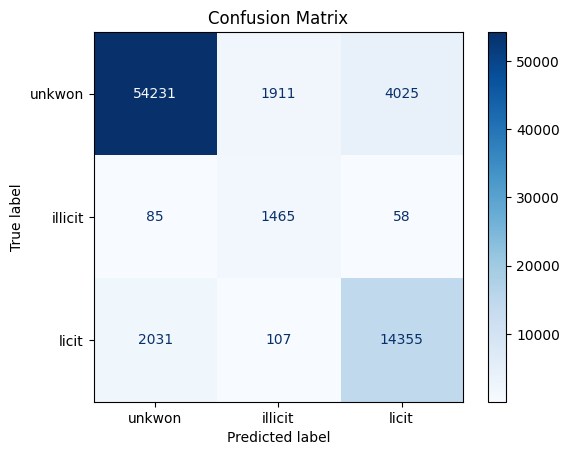

In [ ]:
print(f"Model accieved accuracy of: {test_acc}")
plot_acc(test_data, y_test )

# Pre-train

## Encoder

In [ ]:
# encoder
encoder = MyGCN3(input_dim = data.num_features, hidden_channels=64, n_class=n_classes,self_loops = True).to(device)

seed = 42
set_seed(seed)

loss = train_encoder(epoch=1001,
      data=train_data,
      model = encoder,
      lr = .01,
      wd = 5e-4)


  1%|          | 6/1001 [00:00<00:38, 25.96it/s]

The current loss is 0.7787


 10%|█         | 105/1001 [00:03<00:31, 28.87it/s]

The current loss is 0.0953


 20%|██        | 205/1001 [00:07<00:27, 29.18it/s]

The current loss is 0.0630


 30%|███       | 305/1001 [00:10<00:23, 29.07it/s]

The current loss is 0.0435


 40%|████      | 405/1001 [00:14<00:20, 29.04it/s]

The current loss is 0.0390


 50%|█████     | 505/1001 [00:17<00:17, 28.94it/s]

The current loss is 0.0352


 60%|██████    | 605/1001 [00:21<00:13, 28.94it/s]

The current loss is 0.0297


 70%|███████   | 705/1001 [00:24<00:10, 28.90it/s]

The current loss is 0.0275


 80%|████████  | 805/1001 [00:27<00:06, 28.96it/s]

The current loss is 0.1461


 90%|█████████ | 905/1001 [00:31<00:03, 28.82it/s]

The current loss is 0.0814


100%|██████████| 1001/1001 [00:34<00:00, 28.72it/s]

The current loss is 0.0705


In [ ]:
test_acc, y_test, auc= test_encoder(data = data, model = encoder, bin = True)


Test Accuracy: 0.9693
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       435
           1       0.99      0.98      0.98      4222

    accuracy                           0.97      4657
   macro avg       0.89      0.94      0.92      4657
weighted avg       0.97      0.97      0.97      4657



Encoder accieved accuracy of: 0.9652136568606399
Encoder auc: 0.9385438616551506


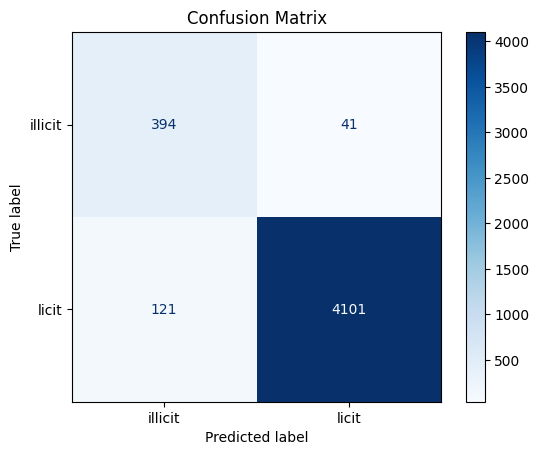

In [ ]:
print(f"Encoder accieved accuracy of: {test_acc}")
print(f"Encoder auc: {auc}")
plot_acc(data, labels = y_test, bin = True)


## Decoder

In [ ]:
import torch.nn as nn
# Set seed
set_seed(42)
criterion = nn.BCEWithLogitsLoss()


epochs = 1000
# initialize model
decoder = Net2(64).to(device)

# Time to train
final_loss, pred, epoch_losses = train_decoder(epoch=epochs,
                                         criterion=criterion,
                                         data=train_data,
                                         model=decoder,
                                         lr=0.01,
                                         wd=5e-4,
                                         device=device,
                                         encoder = encoder)



  0%|          | 2/1000 [00:00<04:28,  3.72it/s]

The current loss is 0.7016


 10%|█         | 102/1000 [00:16<02:25,  6.17it/s]

The current loss is 0.4679


 20%|██        | 202/1000 [00:32<02:05,  6.36it/s]

The current loss is 0.5206


 30%|███       | 302/1000 [00:48<01:53,  6.14it/s]

The current loss is 0.4171


 40%|████      | 402/1000 [01:04<01:37,  6.14it/s]

The current loss is 0.4108


 50%|█████     | 502/1000 [01:20<01:19,  6.29it/s]

The current loss is 0.4066


 60%|██████    | 602/1000 [01:36<01:02,  6.33it/s]

The current loss is 0.3908


 70%|███████   | 702/1000 [01:52<00:46,  6.37it/s]

The current loss is 0.3963


 80%|████████  | 802/1000 [02:08<00:31,  6.37it/s]

The current loss is 0.3917


 90%|█████████ | 902/1000 [02:24<00:16,  6.10it/s]

The current loss is 0.3862


100%|██████████| 1000/1000 [02:41<00:00,  6.20it/s]

The current loss is 0.3833


In [ ]:
score, pred, y_test = test_link(test_data, decoder, device, encoder = encoder)
accuracy = (pred == y_test).mean().item()
print(accuracy)


              precision    recall  f1-score   support

         0.0       0.83      0.98      0.90     74199
         1.0       0.86      0.40      0.54     24733

    accuracy                           0.83     98932
   macro avg       0.85      0.69      0.72     98932
weighted avg       0.84      0.83      0.81     98932

0.8337443900861198


In [ ]:
plot_acc_link(y_test, pred)

NameError: name 'plot_acc_link' is not defined

# Early stopping training

## Train

In [ ]:
# At the start of your training script
torch.cuda.empty_cache()

In [ ]:
import torch.nn as nn

# Set seed
set_seed(42)


# Initialize model
classifier = MyGCNfinal(input_dim = 64, hidden_channels= 64, self_loops = True, is_batch = True).to(device)


criterion = nn.BCEWithLogitsLoss()
epochs = 10
early_stopping = EarlyStopping(tolerance=5, min_delta=0.2)



train_and_val(epochs = epochs,
              device = device,
              criterion = criterion,
              encoder = encoder,
              data = train_data,
              original = data,
              model = decoder,
              lr = 0.01,
              wd = 5e-4,
              classifier = classifier,
              val_data = val_data,
              early_stopping = early_stopping,
              rec_weight = 0.5)



  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([203769, 64])
torch.Size([203769, 64])


 10%|█         | 1/10 [07:16<1:05:28, 436.50s/it]

The current training epoch loss is 1.1008
The current validation epoch loss is 1.3205
torch.Size([203769, 64])
torch.Size([203769, 64])


 20%|██        | 2/10 [14:30<57:58, 434.82s/it]  

The current training epoch loss is 1.4066
The current validation epoch loss is 0.5872
torch.Size([203769, 64])
torch.Size([203769, 64])


 30%|███       | 3/10 [21:42<50:35, 433.70s/it]

The current training epoch loss is 0.7749
The current validation epoch loss is 0.6690
torch.Size([203769, 64])
torch.Size([203769, 64])


 40%|████      | 4/10 [28:55<43:21, 433.57s/it]

The current training epoch loss is 0.8124
The current validation epoch loss is 0.6243
torch.Size([203769, 64])
torch.Size([203769, 64])


 50%|█████     | 5/10 [36:18<36:25, 437.00s/it]

The current training epoch loss is 0.7715
The current validation epoch loss is 0.5315
torch.Size([203769, 64])
torch.Size([203769, 64])


 60%|██████    | 6/10 [43:37<29:09, 437.37s/it]

The current training epoch loss is 0.6603
The current validation epoch loss is 0.5463
torch.Size([203769, 64])
torch.Size([203769, 64])


 70%|███████   | 7/10 [51:05<22:03, 441.06s/it]

The current training epoch loss is 0.6558
The current validation epoch loss is 0.5906
torch.Size([203769, 64])
torch.Size([203769, 64])


 70%|███████   | 7/10 [54:56<23:32, 470.94s/it]


IndexError: index 1 is out of bounds for dimension 1 with size 0

## Test

In [ ]:
test_data

Data(x=[203769, 166], edge_index=[2, 197864], y=[203769], train_mask=[203769], val_mask=[203769], test_mask=[203769], edge_label=[49466], edge_label_index=[2, 49466])

In [ ]:
# Set seed
set_seed(42)

acc, y_test, auc,f= test_final2(test_data, data,encoder = encoder,classifier = classifier, decoder= decoder, device=device)
print(f)
print(f"Test Accuracy: {acc}")
print(f"Test AUC: {auc}")

Test Accuracy: 0.7889
              precision    recall  f1-score   support

           0       0.10      0.16      0.13       435
           1       0.91      0.85      0.88      4222

    accuracy                           0.79      4657
   macro avg       0.51      0.51      0.50      4657
weighted avg       0.83      0.79      0.81      4657

Test Accuracy: 0.7889199055185742
Test AUC: 0.5083027055870454
